Assignment 3

Predicting "fast growing" firms

In [159]:
import os
import pandas as pd
import numpy as np
import sys
from plotnine import *
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [160]:
# Current script folder
path = os.getcwd()

In [161]:
# Import the prewritten helper functions
from py_helper_functions import *

# Import data

In [162]:
csv_path = os.path.join(path,'cs_bisnode_panel.csv')
data = pd.read_csv(csv_path)

In [163]:
# drop variables with many NAs
data = data.drop(columns = ['COGS', 'finished_prod', 'net_dom_sales', 'net_exp_sales', 'wages'])


In [164]:
data

,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,...,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
0,1.001034e+06,2005-01-01,2005-12-31,692.592590,7266.666504,7574.074219,0.0,0.0,0.0,1229.629639,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
1,1.001034e+06,2006-01-01,2006-12-31,603.703674,13122.222656,12211.111328,0.0,0.0,0.0,725.925903,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
2,1.001034e+06,2007-01-01,2007-12-31,425.925934,8196.295898,7800.000000,0.0,0.0,0.0,1322.222168,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
3,1.001034e+06,2008-01-01,2008-12-31,300.000000,8485.185547,7781.481445,0.0,0.0,0.0,1022.222229,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
4,1.001034e+06,2009-01-01,2009-12-31,207.407410,5137.037109,15300.000000,0.0,0.0,0.0,814.814819,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287824,4.641209e+11,2011-01-01,2011-12-31,0.000000,1807.407349,3.703704,0.0,0.0,0.0,0.000000,...,female,Domestic,5510.0,55.0,3.0,2,East,1990-08-22,NaN,NaN
287825,4.641209e+11,2012-01-01,2012-12-31,0.000000,1518.518555,96.296295,0.0,0.0,0.0,0.000000,...,female,Domestic,5510.0,55.0,3.0,2,East,1990-08-22,NaN,NaN
287826,4.641209e+11,2013-01-01,2013-12-31,0.000000,988.888916,77.777779,0.0,0.0,0.0,0.000000,...,NaN,NaN,5510.0,55.0,3.0,2,East,1990-08-22,NaN,NaN
287827,4.641209e+11,2014-01-01,2014-12-31,0.000000,644.444458,233.333328,0.0,0.0,0.0,0.000000,...,female,Domestic,5510.0,55.0,3.0,2,East,1990-08-22,NaN,NaN



# Label engineering


In [165]:
# add all missing year and comp_id combinations -
# originally missing combinations will have NAs in all other columns
data = (
    data.set_index(["year", "comp_id"])
    .unstack(fill_value="toReplace")
    .stack()
    .reset_index()
)
data = data.replace("toReplace", np.nan)  # only way I could define it as NaN

In [166]:
data

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
0,2005,1.001034e+06,2005-01-01,2005-12-31,692.592590,7.266667e+03,7574.074219,0.0,0.000000,0.000000,...,mix,Domestic,5630.0,56.0,3.0,1.0,Central,1990-11-19,NaN,NaN
1,2005,1.001541e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2005,1.002029e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2005,1.003200e+06,2005-01-01,2005-12-31,25.925926,7.296296e+02,3803.703613,0.0,4814.814941,4814.814941,...,NaN,NaN,5630.0,56.0,3.0,1.0,Central,2003-10-21,2014-08-09,NaN
4,2005,1.004012e+06,2005-01-01,2005-12-31,114.814812,1.648148e+03,3777.777832,0.0,0.000000,0.000000,...,male,Domestic,3314.0,33.0,2.0,3.0,West,1991-11-24,2013-06-19,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556939,2016,4.640446e+11,2016-01-01,2016-12-31,78862.960938,5.597182e+06,793370.375000,NaN,NaN,NaN,...,male,Foreign,3312.0,33.0,2.0,3.0,Central,2008-10-09,NaN,3.833333
556940,2016,4.640568e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
556941,2016,4.640793e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
556942,2016,4.641050e+11,2016-01-01,2016-12-31,2522.222168,5.124445e+04,12466.666992,NaN,NaN,NaN,...,mix,Domestic,5610.0,56.0,3.0,3.0,West,1989-04-28,NaN,1.201389


### Predict the fast growth of firms

In [167]:
# generate status_alive; if sales larger than zero and not-NA, then firm is alive
data["status_alive"] = (data["sales"] > 0 & (False == data["sales"].isna())).astype(int)

# defaults in two years if there are sales in this year but no sales two years later
# Status_in_two_years: data.groupby('comp_id')['status_alive'].shift(-2)
data["default"] = (
    (data["status_alive"] == 1)
    & (data.groupby("comp_id")["status_alive"].shift(-2) == 0)
).astype(int)

# Group by comp_id and year
data = data.sort_values(by=["comp_id", "year"])
data= data.reset_index(drop=True)

#Define fast growing firms: if sales growth is larger than 20% in two consecutive years
data["sales_growth"] = data.groupby("comp_id")["sales"].pct_change()
data["fast_growth"] = (
    (data["sales_growth"] > 0.2)
    & (data.groupby("comp_id")["sales_growth"].shift(-1) > 0.2)
).astype(int)


C:\Users\hanic\AppData\Local\Temp\ipykernel_9768\286574720.py:16: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.


In [168]:
data1015 = data.query('year <= 2015')
data1015 = data1015.query('year >= 2010')

In [169]:
data1015['sales'].describe()

count    1.638640e+05
mean     4.662059e+05
std      3.789100e+06
min     -2.553889e+05
25%      3.092593e+03
50%      2.697037e+04
75%      1.060620e+05
max      1.110294e+08
Name: sales, dtype: float64

In [170]:
data1015['fast_growth'].value_counts()

fast_growth
0    266081
1     12391
Name: count, dtype: int64

In [171]:
data1015["sales"] = np.where(
    data1015["sales"] < 0, 1, data1015["sales"]
)  # has to be outside of assin()
data1015 = data1015.assign(
    ln_sales=np.where(
        data1015["sales"] > 0,
        np.log(data1015["sales"]),
        (np.where(data1015["sales"].isna(), np.nan, 0)),
    ),  # NaN remain NaN
    sales_mil=data1015["sales"] / 1000000,
    sales_mil_log=np.where(
        data1015["sales"] > 0,
        np.log(data1015["sales"] / 1000000),
        (np.where(data1015["sales"].isna(), np.nan, 0)),
    ),
)

c:\Users\hanic\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log


In [172]:
data1015

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,founded_date,exit_date,labor_avg,status_alive,default,sales_growth,fast_growth,ln_sales,sales_mil,sales_mil_log
5,2010,1.001034e+06,2010-01-01,2010-12-31,177.777771,2096.296387,19629.628906,0.0,0.0,0.0,...,1990-11-19,NaN,0.083333,1,1,-0.781232,0,9.203278,0.009930,-4.612232
6,2011,1.001034e+06,2011-01-01,2011-12-31,155.555557,3607.407471,22555.554688,0.0,0.0,0.0,...,1990-11-19,NaN,0.083333,0,0,-1.000000,0,0.000000,0.000000,0.000000
7,2012,1.001034e+06,2012-01-01,2012-12-31,140.740738,148.148148,21429.628906,0.0,0.0,0.0,...,1990-11-19,NaN,0.083333,0,0,NaN,0,0.000000,0.000000,0.000000
8,2013,1.001034e+06,2013-01-01,2013-12-31,140.740738,140.740738,21851.851562,0.0,0.0,0.0,...,1990-11-19,NaN,NaN,0,0,NaN,0,0.000000,0.000000,0.000000
9,2014,1.001034e+06,2014-01-01,2014-12-31,29.629629,144.444443,22340.740234,0.0,0.0,0.0,...,1990-11-19,NaN,NaN,0,0,NaN,0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556938,2011,4.641209e+11,2011-01-01,2011-12-31,0.000000,1807.407349,3.703704,0.0,0.0,0.0,...,1990-08-22,NaN,NaN,1,1,0.114286,0,5.666042,0.000289,-8.149468
556939,2012,4.641209e+11,2012-01-01,2012-12-31,0.000000,1518.518555,96.296295,0.0,0.0,0.0,...,1990-08-22,NaN,NaN,0,0,-1.000000,0,0.000000,0.000000,0.000000
556940,2013,4.641209e+11,2013-01-01,2013-12-31,0.000000,988.888916,77.777779,0.0,0.0,0.0,...,1990-08-22,NaN,NaN,0,0,NaN,0,0.000000,0.000000,0.000000
556941,2014,4.641209e+11,2014-01-01,2014-12-31,0.000000,644.444458,233.333328,0.0,0.0,0.0,...,1990-08-22,NaN,NaN,0,0,NaN,0,0.000000,0.000000,0.000000


In [173]:
data1015['d1_sales_mil_log']=data1015['sales_mil_log']-data1015.groupby('comp_id')['sales_mil_log'].shift(1)

In [174]:
# replace w 0 for new firms + add dummy to capture it
data1015["age"] = np.where(
    data1015["year"] - data1015["founded_year"] < 0, 0, data1015["year"] - data1015["founded_year"]
)
data1015["new"] = np.where(
    ((data1015["age"] <= 1) | (data1015["balsheet_notfullyear"] == 1)),
    1,
    (np.where(data1015["age"].isna(), np.nan, 0)),
)
data1015["d1_sales_mil_log"] = np.where(
    data1015["new"] == 1, 0, np.where(data1015["new"].isna(), np.nan, data1015["d1_sales_mil_log"])
)
data1015["new"] = np.where(data1015["d1_sales_mil_log"].isna(), 1, data1015["new"])
data1015["d1_sales_mil_log"] = np.where(
    data1015["d1_sales_mil_log"].isna(), 0, data1015["d1_sales_mil_log"]
)

# Sample design

In [175]:
# look at cross section
dataq = data1015.query("year>=2010 & year<=2015 & status_alive == 1")
# look at firms below 10m euro revenues and above 1000 euros
dataq = dataq.query("sales_mil<=10 & sales_mil>=0.001")

In [176]:
dataq.to_csv("data_2010_to_2015.csv", index=False)

# Feature engineering

In [177]:
data = pd.read_csv("data_2010_to_2015.csv")

In [294]:
data["ind2"]

0         56.0
1         56.0
2         56.0
3         56.0
4         56.0
          ... 
112598    56.0
112599    56.0
112600    56.0
112601    56.0
112602    56.0
Name: ind2, Length: 112603, dtype: float64

In [178]:
# change some industry category codes
data["ind2_cat"] = data["ind2"].copy()
data["ind2_cat"] = np.where(data["ind2"] > 56, 60, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"] < 26, 20, data["ind2_cat"])
data["ind2_cat"] = np.where(
    (data["ind2"] < 55) & (data["ind2"] > 35), 40, data["ind2_cat"]
)
data["ind2_cat"] = np.where(data["ind2"] == 31, 30, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"].isna(), 99, data["ind2_cat"])

In [179]:
data.groupby('ind2_cat').count()['comp_id']

ind2_cat
20.0      310
26.0     6428
27.0     3898
28.0    11606
29.0     1703
30.0     1017
32.0      829
33.0    11371
35.0        2
40.0     1250
55.0    13637
56.0    74806
60.0     1460
99.0       38
Name: comp_id, dtype: int64

In [180]:
# Firm characteristics
data["age2"] = data["age"] ** 2
data["foreign_management"] = np.where(
    data["foreign"] >= 0.5, 1, np.where(data["foreign"].isna(), np.nan, 0)
)
data["gender_m"] = data["gender"].astype("category")
data["m_region_loc"] = data["region_m"].astype("category")

In [181]:
# assets can't be negative. Change them to 0 and add a flag.
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"] < 0)
        | (data["curr_assets"] < 0)
        | (data["fixed_assets"] < 0)
    ),
    1,
    0,
)
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"].isna())
        | (data["curr_assets"].isna())
        | (data["fixed_assets"].isna())
    ),
    np.nan,
    data["flag_asset_problem"],
)
data.groupby("flag_asset_problem").count()["comp_id"]

flag_asset_problem
0.0    128260
1.0        65
Name: comp_id, dtype: int64

Only 7 cases, we can just drop them.

In [182]:
data = data[data["flag_asset_problem"] != 1]

In [183]:
# generate total assets
data["total_assets_bs"] = (
    data["intang_assets"] + data["curr_assets"] + data["fixed_assets"]
)
data["total_assets_bs"].describe()

count    1.282600e+05
mean     2.714614e+05
std      1.874033e+06
min      0.000000e+00
25%      7.592593e+03
50%      2.637222e+04
75%      1.038009e+05
max      3.190691e+08
Name: total_assets_bs, dtype: float64

In [184]:
pl_names = ['extra_exp','extra_inc',  'extra_profit_loss', 'inc_bef_tax' ,'inventories',
              'material_exp', 'profit_loss_year', 'personnel_exp']
bs_names = ['intang_assets', 'curr_liab', 'fixed_assets', 'liq_assets', 'curr_assets',
              'share_eq', 'subscribed_cap', 'tang_assets' ]

In [185]:
# divide all pl_names elements by sales and create new column for it
data[[col + "_pl" for col in pl_names]] = data[pl_names].div(
    data["sales"], axis="index"
)

In [186]:
# divide all bs_names elements by total_assets_bs and create new column for it
data[[col + "_bs" for col in bs_names]] = (
    data[bs_names]
    .div(data["total_assets_bs"], axis="index")
    .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
)
# get Nan values where total_assets_bs is NaN
for col in bs_names:
    data[col + "_bs"] = np.where(
        data["total_assets_bs"].isna(), np.nan, data[col + "_bs"]
    )

In [187]:
########################################################################
# creating flags, and winsorizing tails
########################################################################

# Variables that represent accounting items that cannot be negative (e.g. materials)
zero = [
    "extra_exp_pl",
    "extra_inc_pl",
    "inventories_pl",
    "material_exp_pl",
    "personnel_exp_pl",
    "curr_liab_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
]

data[[col + "_flag_high" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] > 1).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero])
)
data[[col + "_flag_error" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] < 0).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero])
)

In [188]:
# for vars that could be any, but are mostly between -1 and 1
anyof = ["extra_profit_loss_pl", "inc_bef_tax_pl", "profit_loss_year_pl", "share_eq_bs"]

data[[col + "_flag_low" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof])
)
data[[col + "_flag_high" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof])
)
data[[col + "_flag_zero" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int)
)
data[[col + "_quad" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, data[anyof] ** 2
)

In [189]:
# dropping flags with no variation
flag_columns = [col for col in data.columns if "flag" in col]
data = data.drop(
    data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1
)

CEO age:

In [190]:
########################################################################
# additional
# including some imputation
########################################################################

# CEO age
data["ceo_age"] = data["year"] - data["birth_year"]
data = data.assign(
    flag_low_ceo_age=(data["ceo_age"] < 25).astype(int),
    flag_high_ceo_age=(data["ceo_age"] > 75).astype(int),
    flag_miss_ceo_age=(data["ceo_age"].isna()).astype(int),
)


data["ceo_age"] = np.where(data["ceo_age"] < 25, 25, data["ceo_age"])
data["ceo_age"] = np.where(data["ceo_age"] > 75, 75, data["ceo_age"])
data["ceo_age"] = np.where(
    data["ceo_age"].isna(), data["ceo_age"].mean(), data["ceo_age"]
)
data["ceo_young"] = (data["ceo_age"] < 40).astype(int)

In [191]:
#Find correlation between ceo_young and fast_growth, plotting, without grouping
data[['ceo_young','fast_growth']].corr()


,ceo_young,fast_growth
ceo_young,1.000000,0.067048
fast_growth,0.067048,1.000000


We can thus drop this

In [192]:
# number emp, very noisy measure
data["labor_avg_mod"] = np.where(
    data["labor_avg"].isna(), data["labor_avg"].mean(), data["labor_avg"]
)
data["flag_miss_labor_avg"] = (data["labor_avg"].isna()).astype(int)

In [193]:
data['labor_avg'].describe()

count    104349.000000
mean          0.666564
std           1.713188
min           0.000000
25%           0.111111
50%           0.250000
75%           0.568182
max          64.583336
Name: labor_avg, dtype: float64

In [194]:
data['labor_avg_mod'].describe()


count    128290.000000
mean          0.666564
std           1.545085
min           0.000000
25%           0.151515
50%           0.340278
75%           0.666564
max          64.583336
Name: labor_avg_mod, dtype: float64

In [195]:
data = data.drop(['labor_avg'], axis=1)

In [196]:
# create category type variables
data["urban_m"] = data["urban_m"].astype("category")
data["ind2_cat"] = data["ind2_cat"].astype("category")
data["default_f"] = data["default"].astype("category")
data["default_f"] = data["default_f"].cat.rename_categories(["no_default", "default"])

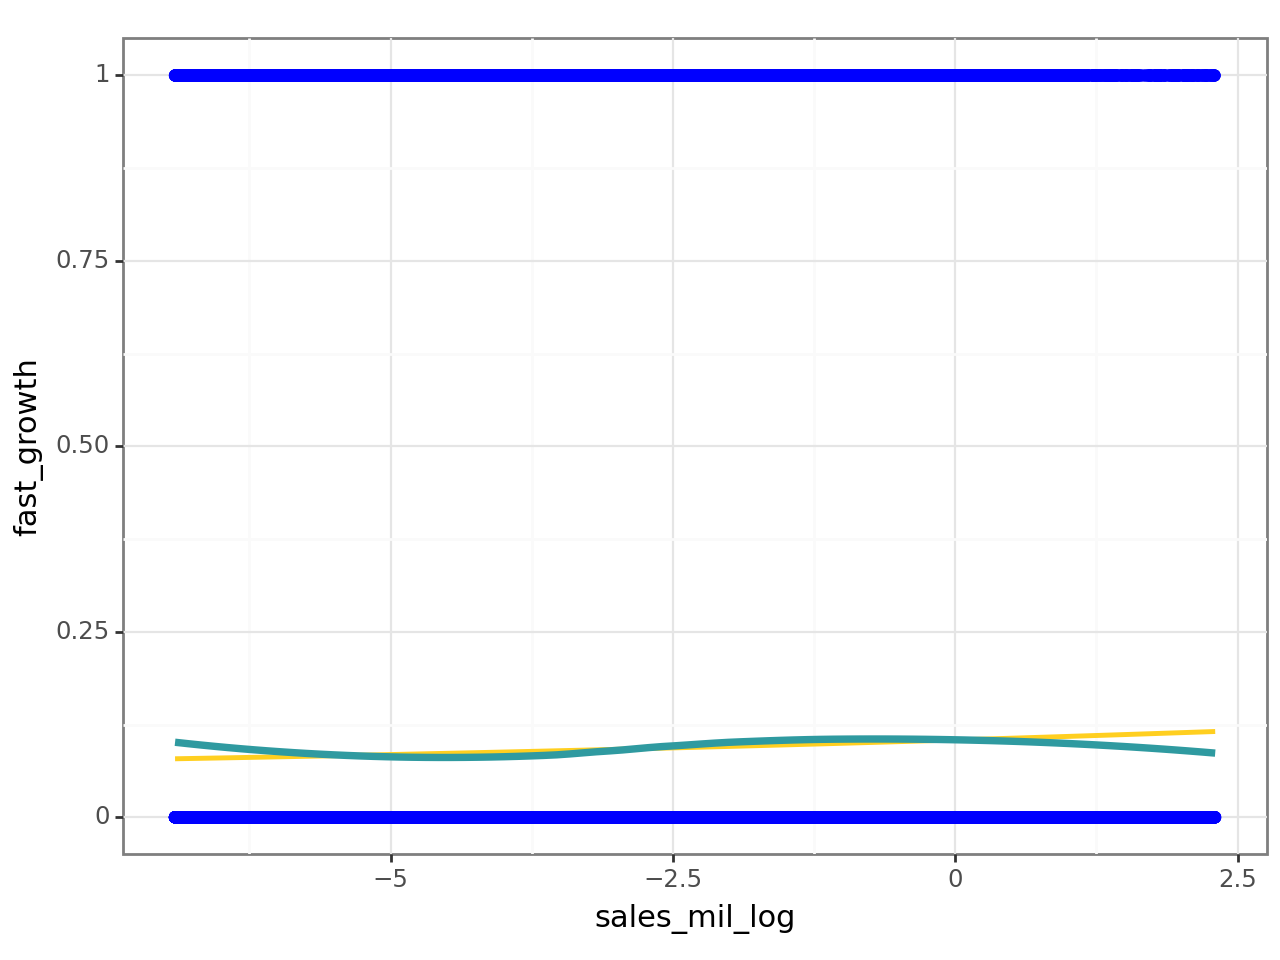

<Figure Size: (640 x 480)>

In [198]:
data["sales_mil_log_sq"] = data["sales_mil_log"] ** 2
ggplot(data, aes(x="sales_mil_log", y="fast_growth")) + geom_point(
    color="blue"
) + geom_smooth(
    method="lm", formula="y ~ x + I(x**2)", color=color[3], se=False
) + geom_smooth(
    method="loess", color=color[4], se=False, size=1.5, span=0.9
) + labs(
    x="sales_mil_log", y="fast_growth"
) + theme_bw()

In [199]:
# Linear regressions
ols_s = smf.ols("default ~ sales_mil_log + sales_mil_log_sq", data=data).fit()
print(ols_s.summary())

                            OLS Regression Results                            
Dep. Variable:                default   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     5492.
Date:                Thu, 14 Dec 2023   Prob (F-statistic):               0.00
Time:                        22:42:21   Log-Likelihood:                -65840.
No. Observations:              128290   AIC:                         1.317e+05
Df Residuals:                  128287   BIC:                         1.317e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0467      0.003  

In [200]:
# lowess
data["d1_sales_mil_log"].describe()

count    128290.000000
mean         -0.034034
std           0.821610
min          -6.907755
25%          -0.054388
50%           0.000000
75%           0.110975
max          11.299683
Name: d1_sales_mil_log, dtype: float64

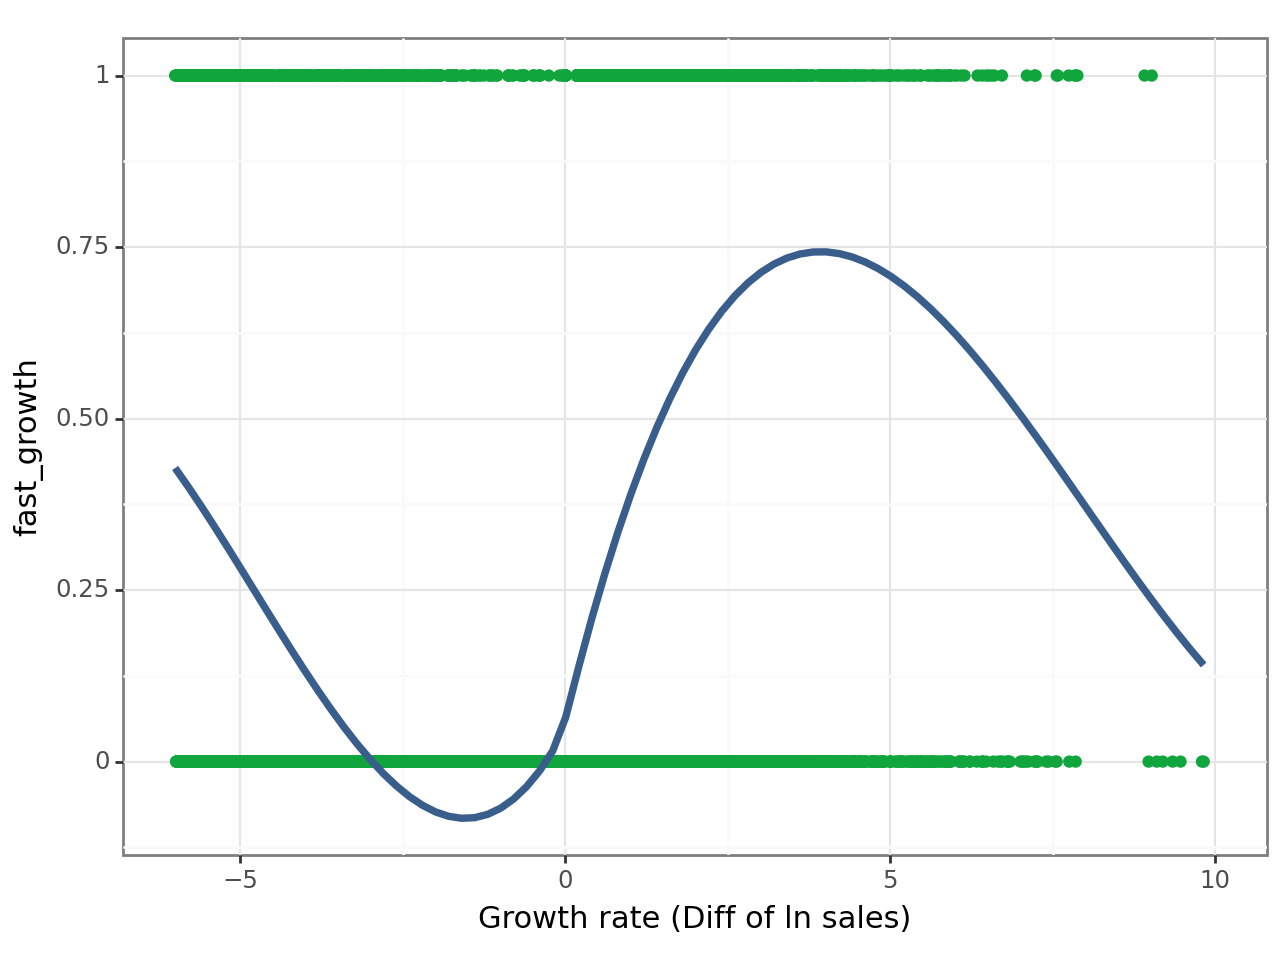

<Figure Size: (640 x 480)>

In [201]:
data2 = data.dropna(subset=['d1_sales_mil_log', 'fast_growth'])
data2 = data2[~((data2['d1_sales_mil_log'] < -6) | (data2['d1_sales_mil_log'] > 10))]#Remove out of limits

ggplot(data2, aes(x="d1_sales_mil_log", y="fast_growth")) + geom_point(
    color=color[1]
) + geom_smooth(method="loess", color=color[0], se=False, size=1.5, span=0.9) + labs(
    x="Growth rate (Diff of ln sales)", y="fast_growth"
) + scale_x_continuous(
    limits=(-6, 10), breaks=seq(-5, 10, by=5)
) + theme_bw()

In [202]:
# generate variables ---------------------------------------------------

data["flag_low_d1_sales_mil_log"] = np.where(data["d1_sales_mil_log"] < -1.5, 1, 0)
data["flag_high_d1_sales_mil_log"] = np.where(data["d1_sales_mil_log"] > 1.5, 1, 0)
data["d1_sales_mil_log_mod"] = np.where(
    data["d1_sales_mil_log"] < -1.5,
    -1.5,
    np.where(data["d1_sales_mil_log"] > 1.5, 1.5, data["d1_sales_mil_log"]),
)
data["d1_sales_mil_log_mod_sq"] = data["d1_sales_mil_log_mod"] ** 2

In [203]:
# no more imputation, drop obs if key vars missing
data = data.dropna(subset=["liq_assets_bs", "foreign", "ind"])

In [204]:
# drop missing
data = data.dropna(subset=["age", "foreign", "material_exp_pl", "m_region_loc"])
data["age"].describe()

count    112603.000000
mean          9.075531
std           7.070909
min           0.000000
25%           3.000000
50%           7.000000
75%          15.000000
max          63.000000
Name: age, dtype: float64

In [205]:
# drop unused factor levels
for col in data.select_dtypes(include=["category"]).columns:
    data[col] = data[col].cat.remove_unused_categories()

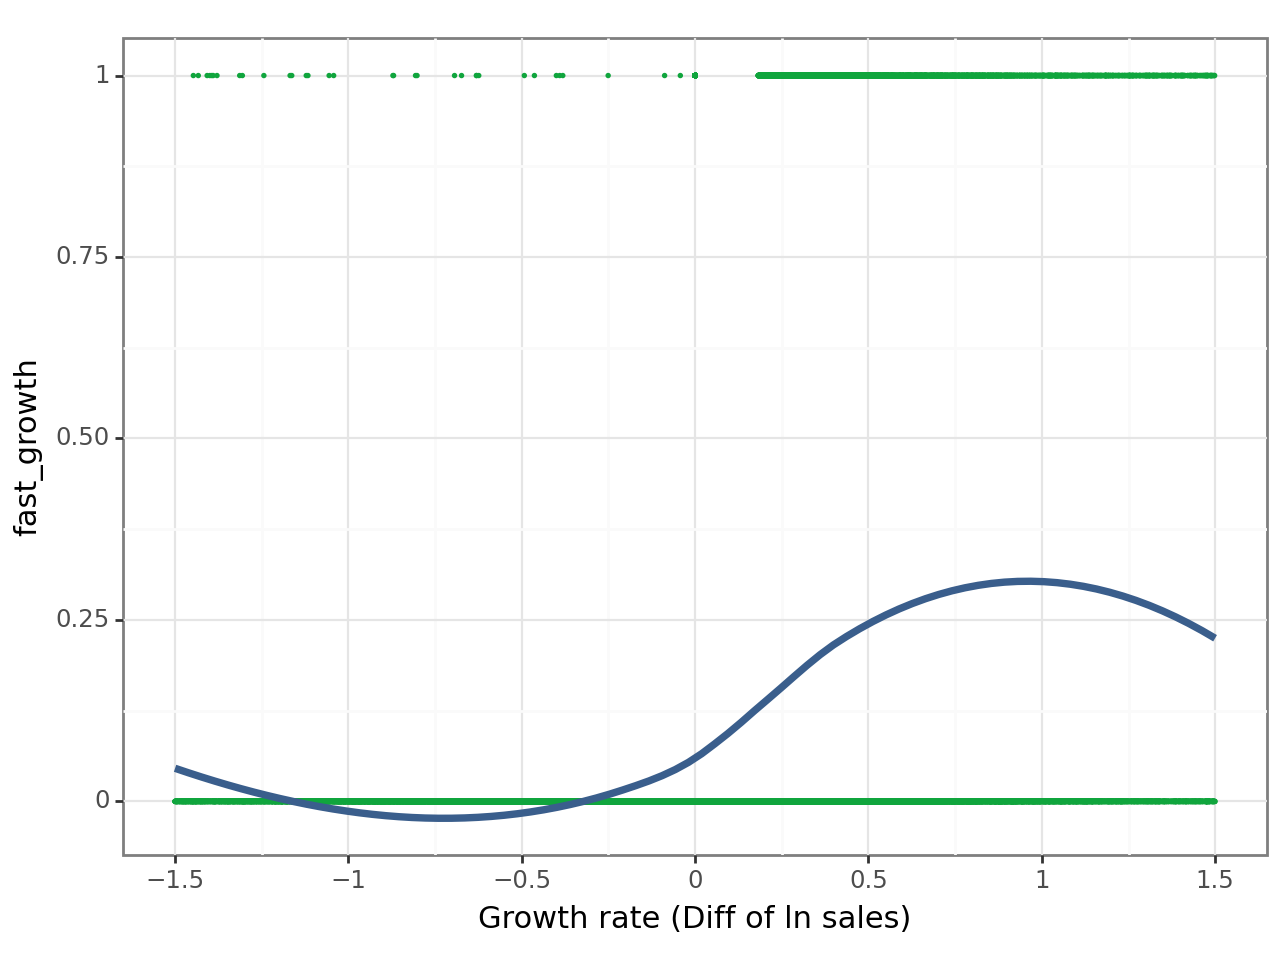

<Figure Size: (640 x 480)>

In [206]:
data2 = data.dropna(subset=['d1_sales_mil_log', 'fast_growth'])
data2 = data2[~((data2['d1_sales_mil_log'] < -1.5) | (data2['d1_sales_mil_log'] > 1.5))]#Remove out of limits

ggplot(data2, aes(x="d1_sales_mil_log", y="fast_growth")) + geom_point(
    size=0.1, color=color[1]
) + geom_smooth(method="loess", color=color[0], se=False, size=1.5, span=0.9) + labs(
    x="Growth rate (Diff of ln sales)", y="fast_growth"
) + scale_x_continuous(
    limits=(-1.5, 1.5), breaks=seq(-1.5, 1.5, by=0.5)
) + theme_bw()

In [207]:
data.columns

Index(['year', 'comp_id', 'begin', 'end', 'amort', 'curr_assets', 'curr_liab',
       'extra_exp', 'extra_inc', 'extra_profit_loss',
       ...
       'flag_miss_ceo_age', 'ceo_young', 'labor_avg_mod',
       'flag_miss_labor_avg', 'default_f', 'sales_mil_log_sq',
       'flag_low_d1_sales_mil_log', 'flag_high_d1_sales_mil_log',
       'd1_sales_mil_log_mod', 'd1_sales_mil_log_mod_sq'],
      dtype='object', length=119)

In [209]:
data = data.drop(['flag_miss_ceo_age','ceo_young'], axis=1)

In [223]:
data = data.drop(['flag_low_ceo_age', 'flag_high_ceo_age'], axis=1)

In [224]:
data.to_csv("firms_2010_2015_clean.csv", index=False)

# Prediction

In [214]:
import warnings

import matplotlib.pyplot as plt
import patsy
import sklearn.metrics as metrics

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    LogisticRegressionCV,
)
from sklearn.metrics import (
    auc,
    brier_score_loss,
    confusion_matrix,
    mean_squared_error,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse

warnings.filterwarnings("ignore")

## Import data

In [225]:
data = pd.read_csv("firms_2010_2015_clean.csv")

In [226]:
data.describe()

,year,comp_id,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,inc_bef_tax,...,profit_loss_year_pl_quad,share_eq_bs_quad,ceo_age,labor_avg_mod,flag_miss_labor_avg,sales_mil_log_sq,flag_low_d1_sales_mil_log,flag_high_d1_sales_mil_log,d1_sales_mil_log_mod,d1_sales_mil_log_mod_sq
count,112603.000000,1.126030e+05,1.126030e+05,1.126030e+05,1.126030e+05,1.125990e+05,1.125990e+05,1.125980e+05,1.126030e+05,1.126030e+05,...,112599.000000,112603.000000,112603.000000,112603.000000,112603.000000,1.126030e+05,112603.000000,112603.000000,112603.000000,112603.000000
mean,2012.559656,1.535628e+11,9.527256e+03,1.065694e+05,8.946544e+04,6.905631e+02,2.073397e+03,1.386389e+03,1.524001e+05,8.240076e+03,...,0.129291,0.484096,47.007076,0.667681,0.178734,1.172203e+01,0.032823,0.019857,-0.002810,0.247387
std,1.697078,1.379206e+11,4.680976e+04,7.659484e+05,6.262035e+05,2.513071e+04,5.805722e+04,6.002882e+04,1.259681e+06,1.737052e+05,...,0.272874,0.388767,10.516815,1.505586,0.383131,1.022941e+01,0.178175,0.139511,0.497374,0.567232
min,2010.000000,1.001034e+06,-5.780000e+04,0.000000e+00,-8.759259e+03,-1.335852e+05,-2.550000e+04,-5.514540e+06,0.000000e+00,-1.835527e+07,...,0.000000,0.000000,25.000000,0.000000,0.000000,3.087363e-09,0.000000,0.000000,-1.500000,0.000000
25%,2011.000000,2.878355e+10,1.740741e+02,3.785185e+03,3.648148e+03,0.000000e+00,0.000000e+00,0.000000e+00,3.851852e+02,-5.170371e+03,...,0.000426,0.090476,39.500000,0.152778,0.000000,3.716248e+00,0.000000,0.000000,-0.085686,0.000000
50%,2013.000000,1.147406e+11,1.037037e+03,1.277037e+04,1.493333e+04,0.000000e+00,0.000000e+00,0.000000e+00,5.488889e+03,4.962963e+02,...,0.007161,0.420664,47.043331,0.340278,0.000000,9.221130e+00,0.000000,0.000000,0.000000,0.013287
75%,2014.000000,2.576230e+11,4.500000e+03,4.418518e+04,4.987222e+04,0.000000e+00,0.000000e+00,0.000000e+00,4.423148e+04,5.400000e+03,...,0.080034,0.947851,54.000000,0.666564,0.000000,1.674367e+01,0.000000,0.000000,0.137955,0.134555
max,2015.000000,4.641050e+11,3.570863e+06,1.411015e+08,1.376625e+08,5.514540e+06,1.197874e+07,1.197874e+07,1.594445e+08,2.943638e+07,...,1.000000,1.000000,75.000000,54.954544,1.000000,4.771708e+01,1.000000,1.000000,1.500000,2.250000


## Define helper functions

In [227]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print("explained_variance: ", round(explained_variance, 4))
    print("r2: ", round(r2, 4))
    print("MAE: ", round(mean_absolute_error, 4))
    print("MSE: ", round(mse, 4))
    print("RMSE: ", round(np.sqrt(mse), 4))


def coef_matrix(X, model):

    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns), pd.DataFrame(np.transpose(model.coef_))], axis=1
    )
    coef_matrix.columns = ["variable", "coefficient"]
    coef_matrix = coef_matrix.append(
        {"variable": "Intercept", "coefficient": model.intercept_},
        ignore_index=True,
    )
    return coef_matrix


def cv_summary(lambdas, C_values, model):
    d = {
        "lambdas": lambdas,
        "C_values": C_values,
        "mean_cv_score": model.scores_[1].mean(axis=0),
    }
    return pd.DataFrame(data=d)


def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({"fpr": fpr, "tpr": tpr, "thresholds": thresholds})

    plot = (
        ggplot(all_coords, aes(x="fpr", y="tpr"))
        + geom_line(color=color[0], size=0.7)
        + geom_area(position="identity", fill="mediumaquamarine", alpha=0.3)
        + xlab("False Positive Rate (1-Specifity)")
        + ylab("True Positive Rate (Sensitivity)")
        + geom_abline(intercept=0, slope=1, linetype="dotted", color="black")
        + scale_y_continuous(limits=(0, 1), breaks=seq(0, 1, 0.1), expand=(0, 0.01))
        + scale_x_continuous(limits=(0, 1), breaks=seq(0, 1, 0.1), expand=(0.01, 0))
        + theme_bw()
    )
    return plot


def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))


def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold, param_index, :]
    return sigmoid_array(
        np.dot(X, np.transpose(fold_coef)[:-1]) + np.transpose(fold_coef)[-1]
    )


def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy["loss"] = (
        all_coords_copy.false_pos * FP + all_coords_copy.false_neg * FN
    ) / all_coords_copy.n

    t = optimal_threshold
    l = curr_exp_loss

    plot = (
        ggplot(all_coords_copy, aes(x="thresholds", y="loss"))
        + geom_line(color=color[0], size=0.7)
        + scale_x_continuous(breaks=seq(0, 1.1, by=0.1))
        + coord_cartesian(xlim=(0, 1))
        + geom_vline(xintercept=t, color=color[0])
        + annotate(
            geom="text",
            x=t - 0.01,
            y=max(all_coords_copy.loss) - 0.4,
            label="best threshold: " + str(round(t, 2)),
            colour=color[1],
            angle=90,
            size=7,
        )
        + annotate(geom="text", x=t + 0.06, y=l, label=str(round(l, 2)), size=7)
        + theme_bw()
    )
    return plot


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy["sp"] = 1 - all_coords_copy.true_neg / all_coords_copy.neg
    all_coords_copy["se"] = all_coords_copy.true_pos / all_coords_copy.pos

    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = (
        ggplot(all_coords_copy, aes(x="sp", y="se"))
        + geom_line(color=color[0], size=0.7)
        + scale_y_continuous(breaks=seq(0, 1.1, by=0.1))
        + scale_x_continuous(breaks=seq(0, 1.1, by=0.1))
        + geom_point(data=pd.DataFrame({"sp": [sp], "se": [se]}))
        + annotate(
            geom="text",
            x=sp,
            y=se + 0.03,
            label=str(round(sp, 2)) + ", " + str(round(se, 2)),
            size=7,
        )
        + geom_area(position="identity", fill="mediumaquamarine", alpha=0.3)
        + xlab("False Positive Rate (1-Specifity)")
        + ylab("True Positive Rate (Sensitivity)")
        + geom_abline(intercept=0, slope=1, linetype="dotted", color="black")
        + theme_bw()
    )
    return plot


## Model building

### Define variable sets 

 Main firm variables

In [228]:
rawvars = [
    "curr_assets",
    "curr_liab",
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "fixed_assets",
    "inc_bef_tax",
    "intang_assets",
    "inventories",
    "liq_assets",
    "material_exp",
    "personnel_exp",
    "profit_loss_year",
    "sales",
    "share_eq",
    "subscribed_cap",
]

Further financial variables

In [229]:
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
engvar = [
    "total_assets_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "share_eq_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
    "extra_exp_pl",
    "extra_inc_pl",
    "extra_profit_loss_pl",
    "inc_bef_tax_pl",
    "inventories_pl",
    "material_exp_pl",
    "profit_loss_year_pl",
    "personnel_exp_pl",
]
engvar2 = [
    "extra_profit_loss_pl_quad",
    "inc_bef_tax_pl_quad",
    "profit_loss_year_pl_quad",
    "share_eq_bs_quad",
]

 Flag variables

In [230]:
engvar3 = []
for col in data.columns:
    if (
        col.endswith("flag_low")
        or col.endswith("flag_high")
        or col.endswith("flag_error")
        or col.endswith("flag_zero")
    ):
        engvar3.append(col)

Growth variables

In [231]:
d1 = [
    "d1_sales_mil_log_mod",
    "d1_sales_mil_log_mod_sq",
    "flag_low_d1_sales_mil_log",
    "flag_high_d1_sales_mil_log",
]

Human capital related variables

In [232]:
hr = [
    "female",
    #"ceo_age",
    #"flag_high_ceo_age",
    #"flag_low_ceo_age",
    #"flag_miss_ceo_age",
    "ceo_count",
    "labor_avg_mod",
    "flag_miss_labor_avg",
    "foreign_management",
]

 Firms history related variables

In [233]:
firm = ["age", "age2", "new", "C(ind2_cat)", "C(m_region_loc)", "C(urban_m)"]

interactions for logit, LASSO

In [234]:
interactions1 = [
    "C(ind2_cat)*age",
    "C(ind2_cat)*age2",
    "C(ind2_cat)*d1_sales_mil_log_mod",
    "C(ind2_cat)*sales_mil_log",
    "C(ind2_cat)*ceo_age",
    "C(ind2_cat)*foreign_management",
    "C(ind2_cat)*female",
    "C(ind2_cat)*C(urban_m)",
    "C(ind2_cat)*labor_avg_mod",
]
interactions2 = [
    "sales_mil_log*age",
    "sales_mil_log*female",
    "sales_mil_log*profit_loss_year_pl",
    "sales_mil_log*foreign_management",
]

## Model setups

1. Simple logit models

In [235]:
M1 = [
    "sales_mil_log",
    "sales_mil_log_sq",
    "d1_sales_mil_log_mod",
    "profit_loss_year_pl",
    "C(ind2_cat)",
]
M2 = [
    "sales_mil_log",
    "sales_mil_log_sq",
    "d1_sales_mil_log_mod",
    "profit_loss_year_pl",
    "fixed_assets_bs",
    "share_eq_bs",
    "curr_liab_bs ",
    "curr_liab_bs_flag_high ",
    "curr_liab_bs_flag_error",
    "age",
    "foreign_management",
    "C(ind2_cat)",
]
M3 = ["sales_mil_log", "sales_mil_log_sq"] + firm + engvar + d1
M4 = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + firm
    + engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + qualityvars
)
M5 = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + firm
    + engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + qualityvars
    + interactions1
    + interactions2
)

2. logit+LASSO

In [236]:
logit_lasso_vars = (
    ["sales_mil_log", "sales_mil_log_sq"]
    + engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + firm
    + qualityvars
    + interactions1
    + interactions2
)

3. CART and RF (no interactions, no modified features)

In [237]:
rfvars = ["sales_mil", "d1_sales_mil_log"] + rawvars + hr + firm + qualityvars

## Quick reminder about probability models

 Linear probability model

In [247]:
ols_modelx2 = smf.ols("fast_growth~" + "+".join(M2), data).fit(cov_type="HC1")
ols_modelx2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fast_growth   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     238.6
Date:                Thu, 14 Dec 2023   Prob (F-statistic):               0.00
Time:                        23:51:03   Log-Likelihood:                -18391.
No. Observations:              112599   AIC:                         3.682e+04
Df Residuals:                  112580   BIC:                         3.700e+04
Df Model:                          18                                         
Covariance Type:                  HC1                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.1420      0.005     28.127      0.000       0.132       0.152
C(ind2_cat)[T.27.0]         0.0067      0.006      1.149      0.250      -0.005       0.018
C(ind2_cat)[T.28.0]         0.0041      0.004      0.940      0.347      -0.004       0.013
C(ind2_cat)[T.29.0]         0.0295      0.009      3.360      0.001       0.012       0.047
C(ind2_cat)[T.30.0]         0.0232      0.011      2.116      0.034       0.002       0.045
C(ind2_cat)[T.33.0]        -0.0040      0.004     -0.903      0.367      -0.013       0.005
C(ind2_cat)[T.55.0]        -0.0043      0.005     -0.962      0.336      -0.013       0.004
C(ind2_cat)[T.56.0]        -0.0167      0.004     -4.403      0.000      -0.024      -0.009
sales_mil_log               0.0078      0.001      5.719      0.000       0.005       0.010
sales_mil_log_sq            0.0019      0.000      8.383      0.000       0.001       0.002
d1_sales_mil_log_mod        0.1111      0.002     45.280      0.000       0.106       0.116
profit_loss_year_pl        -0.0027      0.003     -0.939      0.348      -0.008       0.003
fixed_assets_bs             0.0114      0.003      4.134      0.000       0.006       0.017
share_eq_bs                -0.0090      0.002     -4.126      0.000      -0.013      -0.005
curr_liab_bs                0.0235      0.004      5.891      0.000       0.016       0.031
curr_liab_bs_flag_high     -0.0295      0.004     -8.278      0.000      -0.037      -0.023
curr_liab_bs_flag_error    -0.0270      0.022     -1.232      0.218      -0.070       0.016
age                        -0.0050      0.000    -38.440      0.000      -0.005      -0.005
foreign_management          0.0070      0.003      2.329      0.020       0.001       0.013
==============================================================================
Omnibus:                    56325.893   Durbin-Watson:                   1.765
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           251623.725
Skew:                           2.578   Prob(JB):                         0.00
Kurtosis:                       8.201   Cond. No.                         904.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [248]:
logit_modelx2 = smf.logit("fast_growth~" + "+".join(M2), data).fit()

Optimization terminated successfully.
         Current function value: 0.286348
         Iterations 8


## 0. Separate train and holdout data

In [242]:
data_train, data_holdout = train_test_split(data, train_size=0.8, random_state=42)

In [253]:
print("Total")
print(data["fast_growth"].value_counts(normalize=True))
print("Train")
print(data_train["fast_growth"].value_counts(normalize=True))
print("Holdout")
print(data_holdout["fast_growth"].value_counts(normalize=True))


Total
fast_growth
0    0.905553
1    0.094447
Name: proportion, dtype: float64
Train
fast_growth
0    0.904776
1    0.095224
Name: proportion, dtype: float64
Holdout
fast_growth
0    0.908663
1    0.091337
Name: proportion, dtype: float64


## 1. Predict probabilities with logit and Lasso with CV

Specify 5 fold cross-validation method

In [251]:
k = KFold(n_splits=5, shuffle=True, random_state=42)

### a) cross validate logit models

Set up X-vars

In [252]:
logit_model_vars = [M1, M2, M3, M4, M5]

Set up Logit model object

No regularisation needed so setting the paremeter to very high value

In [254]:
C_value_logit = [1e20]

In [255]:
logit_models = dict()
CV_RMSE_folds = dict()

for i, model_vars in enumerate(logit_model_vars):

    model_equation = "fast_growth~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_brier = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="neg_brier_score",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    logit_models["M" + str(i + 1)] = LRCV_brier.fit(X_train, y_train)

    # Calculate RMSE on test for each fold
    CV_RMSE_folds["M" + str(i + 1)] = np.sqrt(
        -1 * logit_models["M" + str(i + 1)].scores_[1].ravel()
    )

In [256]:
pd.DataFrame(CV_RMSE_folds)

,M1,M2,M3,M4,M5
0,0.281675,0.280281,0.469000,0.468999,0.468999
1,0.286538,0.284391,0.465060,0.465056,0.465056
2,0.286087,0.284359,0.285614,0.285802,0.282504
3,0.288727,0.286810,0.469106,0.469106,0.469105
4,0.286618,0.284769,0.462586,0.462583,0.462583


### b) Logit + LASSO

In [257]:
model_equation = "fast_growth~" + "+".join(logit_lasso_vars)
y_train, X_train = patsy.dmatrices(model_equation, data_train)

Normalise X vars for Lasso

In [258]:
normalized_logitvars = pd.DataFrame(
    StandardScaler().fit_transform(X_train),
    columns=X_train.design_info.column_names,
)

Set regularization parameters

In [259]:
lambdas = list(10 ** np.arange(-1, -4.01, -1 / 3))
n_obs = normalized_logitvars.shape[0] * 4 / 5
C_values = [
    1 / (l * n_obs) for l in lambdas
]  # Cs are the inverse of regularization strength

Initialize and fit Logit Lasso

In [260]:
logLasso_brier = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="neg_brier_score",
    solver="liblinear",
    random_state=42,
)

logit_models["LASSO"] = logLasso_brier.fit(normalized_logitvars, y_train)

See CV-fold RMSE-s (negative brier score)

In [261]:
cv_summary_lasso = cv_summary(lambdas, C_values, logit_models["LASSO"])
cv_summary_lasso["mean_cv_score"] = np.sqrt(cv_summary_lasso["mean_cv_score"] * -1)
cv_summary_lasso

,lambdas,C_values,mean_cv_score
0,0.100000,0.000139,0.310102
1,0.046416,0.000299,0.295579
2,0.021544,0.000644,0.287005
3,0.010000,0.001388,0.281403
4,0.004642,0.002990,0.279075
5,0.002154,0.006441,0.276381
6,0.001000,0.013877,0.274555
7,0.000464,0.029897,0.273895
8,0.000215,0.064412,0.273874
9,0.000100,0.138772,0.273947


Save best lambda's index for later use

In [262]:
best_lambda_i = cv_summary_lasso["mean_cv_score"].idxmin()

Extract CV test RMSE for the Lasso with best lambda

In [263]:
CV_RMSE_folds["LASSO"] = np.sqrt(
    -1 * logit_models["LASSO"].scores_[1][:, best_lambda_i]
)

## 2.  AUC, Calibration Curve, Confusion Matrix, ROC

0. Calculate AUC for folds


First, for logits

In [264]:
CV_AUC_folds = dict()
for i, model_vars in enumerate(logit_model_vars):

    model_equation = "fast_growth~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_auc = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="roc_auc",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    logit_models["M" + str(i + 1)] = LRCV_auc.fit(X_train, y_train)

    # Calculate AUC on test for each fold
    CV_AUC_folds["M" + str(i + 1)] = logit_models["M" + str(i + 1)].scores_[1].ravel()

For Lasso

In [265]:
logLasso_auc = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="roc_auc",
    solver="liblinear",
    random_state=42,
)
logLasso_auc_fitted = logLasso_auc.fit(normalized_logitvars, y_train)

CV_AUC_folds["LASSO"] = logLasso_auc_fitted.scores_[1][
    :, cv_summary_lasso["mean_cv_score"].idxmin()
]

Put a summary frame together

In [266]:
model_fits = pd.DataFrame(logit_models, index=["Model fit"]).T

summary = (
    model_fits["Model fit"]
    .apply(lambda x: x.n_features_in_)
    .to_frame(name="Number of Coefficients")
)

summary.loc["LASSO", "Number of Coefficients"] = len(
    [i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0]
)

summary["CV RMSE"] = pd.DataFrame(CV_RMSE_folds).T.mean(axis=1)
summary["CV AUC"] = pd.DataFrame(CV_AUC_folds).T.mean(axis=1)

In [267]:
sum(x != 0 for x in model_fits.loc["LASSO"].values[0].coef_[0].tolist())

106

In [268]:
len(
    [i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0]
)

106

In [269]:
summary

,Number of Coefficients,CV RMSE,CV AUC
M1,12,0.285929,0.725521
M2,19,0.284122,0.737328
M3,36,0.430273,0.536885
M4,76,0.430309,0.536466
M5,151,0.429649,0.545269
LASSO,106,0.273869,0.837628


### Take best model and estimate RMSE on holdout  

M4, M5 and LASSO are practically the same - go with the simplest model, M4

In [270]:
best_logit = logit_models["M4"]
lasso = logit_models["LASSO"]
model_equation = "fast_growth~" + "+".join(M4)
_, X_holdout = patsy.dmatrices(model_equation, data_holdout)

Best logit holdout RMSE and AUROC


In [295]:
data_holdout["best_logit_pred_proba"] = best_logit.predict_proba(X_holdout)[:, 1]
print(round(rmse(data_holdout["best_logit_pred_proba"], data_holdout["fast_growth"]), 3))
print(round(roc_auc_score(data_holdout["fast_growth"], data_holdout["best_logit_pred_proba"]), 3))

0.277
0.77


In [283]:
model_equation = "fast_growth~" + "+".join(logit_lasso_vars)
_, X_holdout_lasso = patsy.dmatrices(model_equation, data_holdout)


data_holdout["best_lasso_pred_proba"]= lasso.predict_proba(X_holdout_lasso)[:, 1]
print(round(rmse(data_holdout["fast_growth"], data_holdout["best_lasso_pred_proba"]), 3))
round(roc_auc_score(data_holdout["fast_growth"], data_holdout["best_lasso_pred_proba"]), 3)


0.944


0.496

There is something wrong with the LASSO prediction, it almost totally predicts fast growth, seems like roles are reversed.
I thus switch roles of 0 and 1 in the LASSO prediction.

In [313]:
data_holdout["best_lasso_pred_proba"] = 1 - data_holdout["best_lasso_pred_proba"]

### a) Calibration curve

how well do estimated vs actual event probabilities relate to each other?


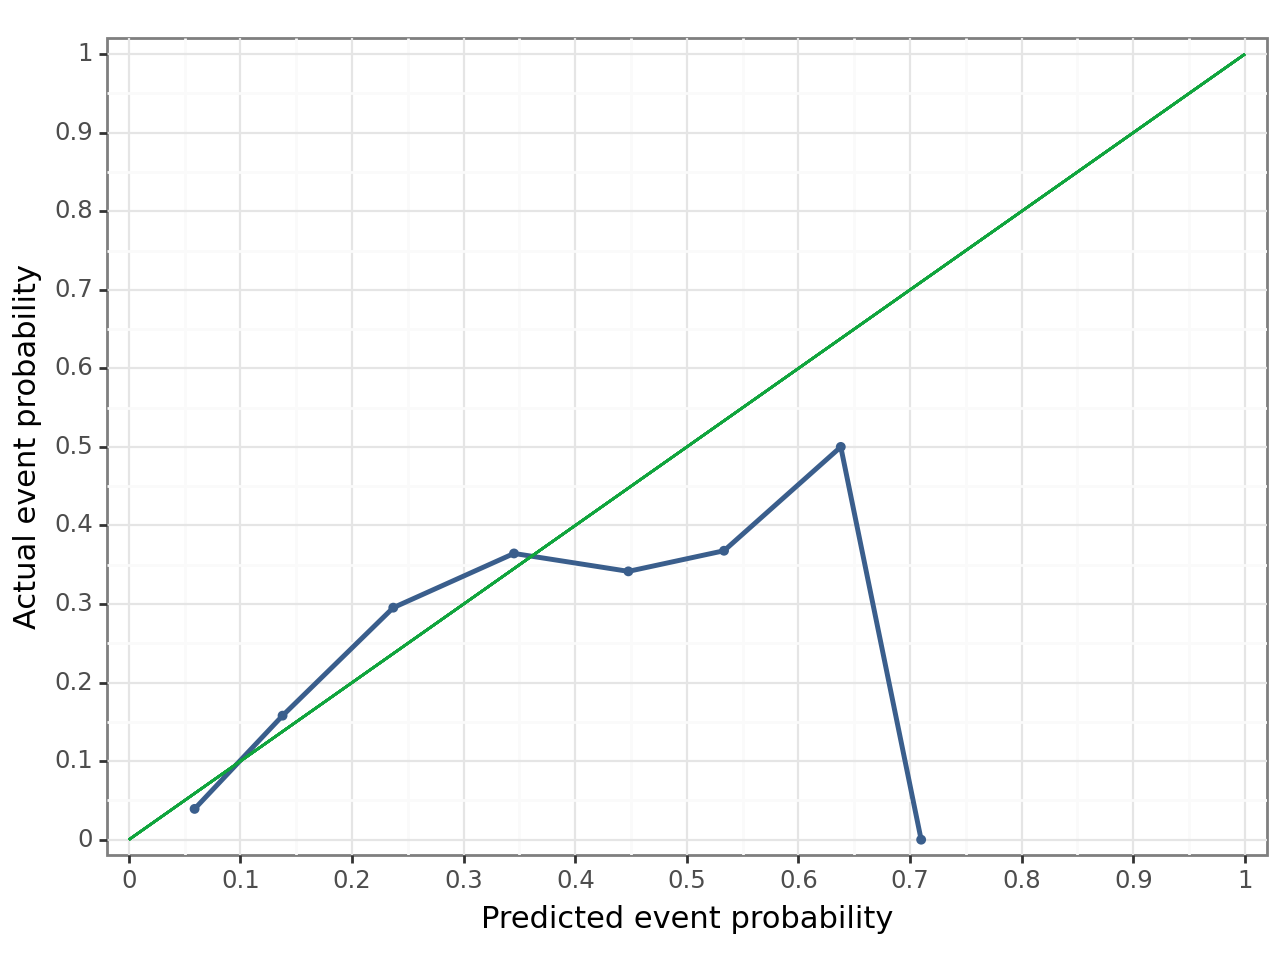

<Figure Size: (640 x 480)>

In [296]:
create_calibration_plot(
    data_holdout,
    file_name="ch17-figure-1-logit-m4-calibration",
    prob_var="best_logit_pred_proba",
    actual_var="fast_growth",
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
)


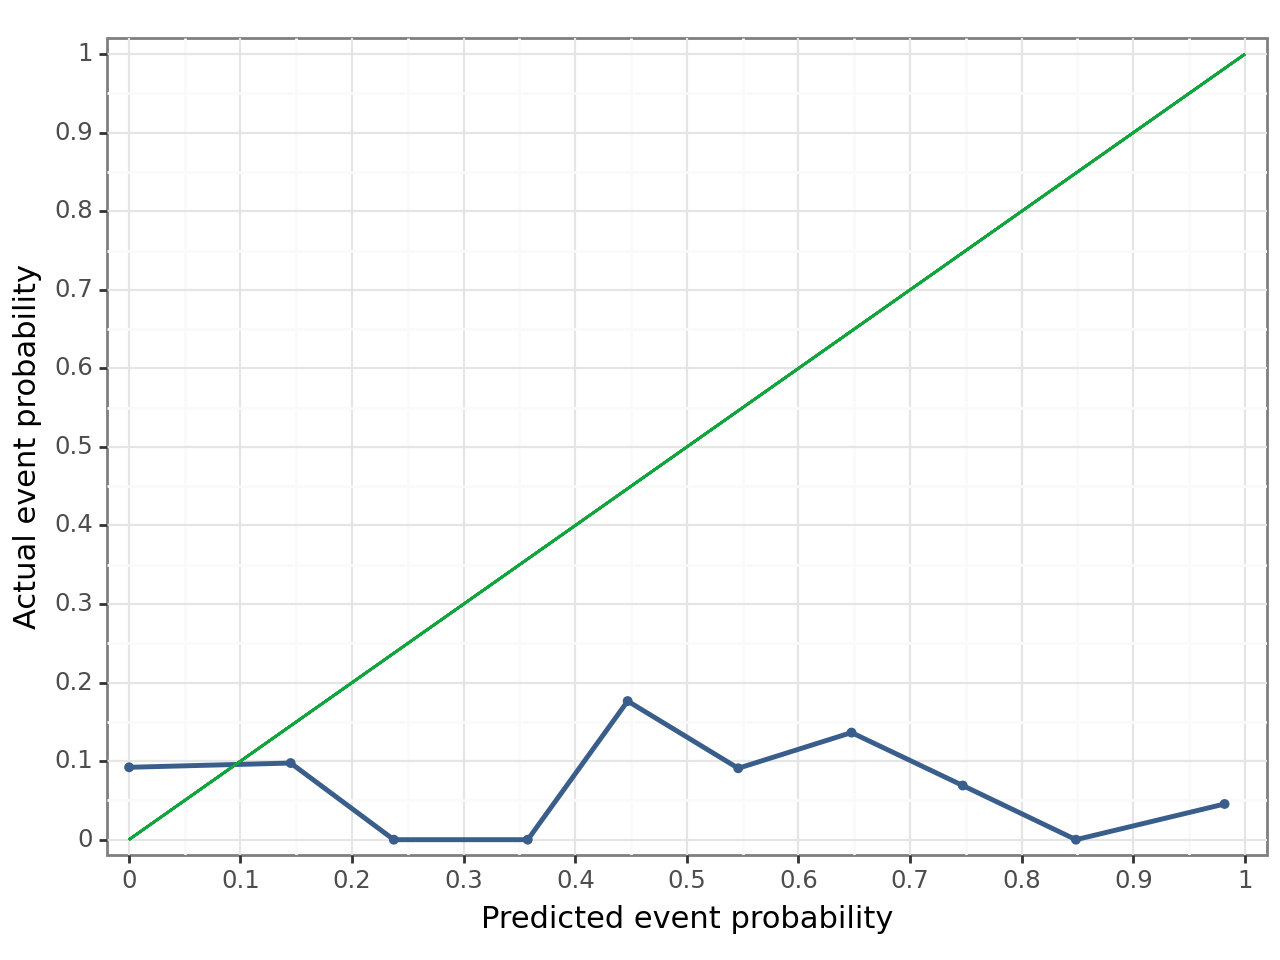

<Figure Size: (640 x 480)>

In [314]:
create_calibration_plot(
    data_holdout,
    file_name="ch17-figure-2-logit-lasso-calibration",
    prob_var="best_lasso_pred_proba",
    actual_var="fast_growth",
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
)

In [316]:
data_holdout['fast_growth'].value_counts()

fast_growth
0    20464
1     2057
Name: count, dtype: int64

In [315]:
data_holdout['prob_bin'].value_counts()

prob_bin
(-0.001, 0.1]    22047
(0.9, 1.0]         264
(0.8, 0.9]          42
(0.1, 0.2]          41
(0.2, 0.3]          29
(0.7, 0.8]          29
(0.6, 0.7]          22
(0.3, 0.4]          19
(0.4, 0.5]          17
(0.5, 0.6]          11
Name: count, dtype: int64

In [317]:
data_holdout

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,flag_miss_labor_avg,default_f,sales_mil_log_sq,flag_low_d1_sales_mil_log,flag_high_d1_sales_mil_log,d1_sales_mil_log_mod,d1_sales_mil_log_mod_sq,best_logit_pred_proba,best_lasso_pred_proba,prob_bin
39254,2015,5.551813e+10,2015-01-01,2015-12-31,0.000000,1629.629639,4525.925781,0.000000,0.0,0.000000,...,0,no_default,16.112972,0,0,-0.064910,0.004213,0.031436,0.000000e+00,"(-0.001, 0.1]"
96699,2012,3.405354e+11,2012-01-01,2012-12-31,1388.888916,4911.111328,670.370361,0.000000,0.0,0.000000,...,1,no_default,28.988720,0,0,1.189815,1.415659,0.383049,0.000000e+00,"(-0.001, 0.1]"
30417,2013,3.357183e+10,2013-01-01,2013-12-31,0.000000,2007.407349,3522.222168,0.000000,0.0,0.000000,...,1,no_default,32.507817,0,0,-0.166116,0.027594,0.032218,0.000000e+00,"(-0.001, 0.1]"
6815,2013,1.750273e+09,2013-01-01,2013-12-31,0.000000,37.037037,15988.888672,0.000000,0.0,0.000000,...,0,default,15.846908,0,0,0.275001,0.075625,0.102349,9.971371e-01,"(0.9, 1.0]"
15243,2012,8.413115e+09,2012-01-01,2012-12-31,859.259277,8722.222656,16751.851562,0.000000,0.0,0.000000,...,0,default,9.218319,0,0,-0.180327,0.032518,0.090424,0.000000e+00,"(-0.001, 0.1]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68473,2010,1.691646e+11,2010-01-01,2010-12-31,1533.333374,29933.333984,2737.037109,0.000000,0.0,0.000000,...,0,no_default,7.970172,0,0,0.000000,0.000000,0.073808,0.000000e+00,"(-0.001, 0.1]"
41322,2010,6.156554e+10,2010-01-01,2010-12-31,907.407410,1437.036987,3296.296387,555.555542,0.0,-555.555542,...,1,no_default,14.789792,0,0,0.000000,0.000000,0.152395,1.389252e-07,"(-0.001, 0.1]"
92853,2011,3.133448e+11,2011-01-01,2011-12-31,4885.185059,146033.328125,21718.517578,0.000000,0.0,0.000000,...,0,no_default,3.622124,0,0,-0.337926,0.114194,0.031101,0.000000e+00,"(-0.001, 0.1]"
63011,2011,1.436084e+11,2011-01-01,2011-12-31,237.037033,4811.111328,2925.926025,0.000000,0.0,0.000000,...,1,no_default,24.463873,0,0,-0.318454,0.101413,0.032060,0.000000e+00,"(-0.001, 0.1]"


This would mean that the LASSO is very much focused on the most likely case, 

### b) Confusion table with different tresholds

The threshold 0.5 is used to convert probabilities to binary classes

In [307]:
logit_class_prediction = best_logit.predict(X_holdout)

values, counts = np.unique(logit_class_prediction.tolist(), return_counts=True)
print(values[0], " (no fast growth): ", counts[0])
print(values[1], " (fast growth): ", counts[1])

0.0  (no fast growth):  22429
1.0  (fast growth):  92


In [320]:
lasso_class_prediction = lasso.predict(X_holdout_lasso)
lasso_class_prediction = 1 - lasso_class_prediction

values, counts = np.unique(lasso_class_prediction.tolist(), return_counts=True)
print(values[0], " (no fast growth): ", counts[0])
print(values[1], " (fast growth): ", counts[1])

0.0  (no fast growth):  22153
1.0  (fast growth):  368


Confusion matrix: summarize different type of errors and successfully predicted cases

positive = "yes": explicitly specify the positive case

In [310]:
cm_object1 = confusion_matrix(
    data_holdout["fast_growth"], logit_class_prediction, labels=[0, 1]
)
cm1 = pd.DataFrame(
    cm_object1,
    index=["Actul no fast growth", "Actual fast growth"],
    columns=["Predicted no fast growth", "Predicted fast growth"],
)
cm1

,Predicted no fast growth,Predicted fast growth
Actul no fast growth,20406,58
Actual fast growth,2023,34


In [321]:
cm_object2 = confusion_matrix(
    data_holdout["fast_growth"], lasso_class_prediction, labels=[0, 1]
)
cm2 = pd.DataFrame(
    cm_object2,
    index=["Actul no fast growth", "Actual fast growth"],
    columns=["Predicted no fast growth", "Predicted fast growth"],
)
cm2

,Predicted no fast growth,Predicted fast growth
Actul no fast growth,20114,350
Actual fast growth,2039,18


In [336]:
# we can apply different thresholds

# 0.5 same as before
holdout_prediction = np.where(data_holdout["best_logit_pred_proba"] < 0.5, 0, 1)
cm_object1b = confusion_matrix(
    data_holdout["fast_growth"], holdout_prediction, labels=[0, 1]
)
cm1b = pd.DataFrame(
    cm_object1b,
    index=["Actul no fast growth", "Actual fast growth"],
    columns=["Predicted no fast growth", "Predicted fast growth"],
)
cm1b

,Predicted no fast growth,Predicted fast growth
Actul no fast growth,20406,58
Actual fast growth,2023,34


A sensible choice: mean of predicted probabilities

In [323]:
mean_predicted_fast_growth_prob = np.mean(data_holdout["best_logit_pred_proba"])
round(mean_predicted_fast_growth_prob, 3)

0.097

In [341]:
holdout_prediction = np.where(
    data_holdout["best_logit_pred_proba"] < mean_predicted_fast_growth_prob, 0, 1
)
cm_object2 = confusion_matrix(
    data_holdout["fast_growth"], holdout_prediction, labels=[0, 1]
)
cm2 = pd.DataFrame(
    cm_object2,
    index=["Actul no fast growth", "Actual fast growth"],
    columns=["Predicted no fast growth", "Predicted fast growth"],
)
cm2

,Predicted no fast growth,Predicted fast growth
Actul no fast growth,13536,6928
Actual fast growth,544,1513


In [339]:
#But even better would be to use the optimal threshold


def optimal_threshold(data, prob_var, actual_var, cost_matrix):

    # Create a dataframe with all possible thresholds
    all_coords = pd.DataFrame(
        {
            "thresholds": np.linspace(0, 1, 100),
            "true_pos": np.nan,
            "false_pos": np.nan,
            "true_neg": np.nan,
            "false_neg": np.nan,
            "n": np.nan,
        }
    )

    # Calculate confusion matrix for each threshold
    for i, threshold in enumerate(all_coords["thresholds"]):
        cm_object = confusion_matrix(
            data[actual_var], np.where(data[prob_var] < threshold, 0, 1), labels=[0, 1]
        )
        all_coords.loc[i, "true_pos"] = cm_object[1, 1]
        all_coords.loc[i, "false_pos"] = cm_object[0, 1]
        all_coords.loc[i, "true_neg"] = cm_object[0, 0]
        all_coords.loc[i, "false_neg"] = cm_object[1, 0]
        all_coords.loc[i, "n"] = np.sum(cm_object)

    # Calculate expected loss for each threshold
    all_coords["loss"] = (
        all_coords.false_pos * cost_matrix[0, 1]
        + all_coords.false_neg * cost_matrix[1, 0]
    ) / all_coords.n

    # Calculate optimal threshold
    optimal_threshold = all_coords.loc[all_coords.loss.idxmin(), "thresholds"]

    # Calculate expected loss for optimal threshold
    curr_exp_loss = all_coords.loc[all_coords.thresholds == optimal_threshold, "loss"]

    return optimal_threshold, curr_exp_loss


cost_matrix = np.array([[0, 1], [1, 0]])

optimal_threshold_val, curr_exp_loss = optimal_threshold(
    data_holdout, "best_logit_pred_proba", "fast_growth", cost_matrix
)

print("Optimal threshold: ", round(optimal_threshold_val, 2))
print("Expected loss: ", round(curr_exp_loss.values[0], 2))


Optimal threshold:  0.67
Expected loss:  0.09


In [340]:

holdout_prediction = np.where(
    data_holdout["best_logit_pred_proba"] < optimal_threshold_val, 0, 1
)
cm_object2 = confusion_matrix(
    data_holdout["fast_growth"], holdout_prediction, labels=[0, 1]
)
cm2 = pd.DataFrame(
    cm_object2,
    index=["Actul no fast growth", "Actual fast growth"],
    columns=["Predicted no fast growth", "Predicted fast growth"],
)
cm2

,Predicted no fast growth,Predicted fast growth
Actul no fast growth,20463,1
Actual fast growth,2056,1


This is an "overkill", so let's choose 0.25

In [342]:
holdout_prediction = np.where(
    data_holdout["best_logit_pred_proba"] < 0.25, 0, 1
)
cm_object3 = confusion_matrix(
    data_holdout["fast_growth"], holdout_prediction, labels=[0, 1]
)
cm3 = pd.DataFrame(
    cm_object3,
    index=["Actul no fast growth", "Actual fast growth"],
    columns=["Predicted no fast growth", "Predicted fast growth"],
)
cm3

,Predicted no fast growth,Predicted fast growth
Actul no fast growth,19954,510
Actual fast growth,1787,270


In [343]:
#Lasso covariance matrix with 0.25 threshold

holdout_prediction = np.where(
    data_holdout["best_lasso_pred_proba"] < 0.25, 0, 1
)
cm_object4 = confusion_matrix(
    data_holdout["fast_growth"], holdout_prediction, labels=[0, 1]
)
cm4 = pd.DataFrame(
    cm_object4,
    index=["Actul no fast growth", "Actual fast growth"],
    columns=["Predicted no fast growth", "Predicted fast growth"],
)
cm4


,Predicted no fast growth,Predicted fast growth
Actul no fast growth,20072,392
Actual fast growth,2036,21


In [344]:
np.arange(0.05, 0.76, 0.05)

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75])

### c) Visualize ROC (with thresholds in steps) on holdout

What if we want to compare multiple thresholds?

First, discrete ROC (with thresholds in steps) on holdout

In [348]:
thresholds = np.arange(0.03, 0.76, 0.03)
#thresholds = sorted(np.geomspace(0.95, 0.05, num=17)) # set these treshold values to get even points in the plot
cm = dict()
true_positive_rates = []
false_positive_rates = []
holdout_prediction = []
for thr in thresholds:
    holdout_prediction = np.where(data_holdout["best_logit_pred_proba"] < thr, 0, 1)
    cm_thr = confusion_matrix(data_holdout["fast_growth"], holdout_prediction, labels=[0, 1])
    cm[thr] = cm_thr
    tn, fp, fn, tp = cm_thr.ravel()
    true_positive_rates.append(tp / (tp + fn))
    false_positive_rates.append(fp / (fp + tn))

In [349]:
tpr_fpr_for_thresholds = pd.DataFrame(
    {
        "thresholds": thresholds,
        "true_positive_rates": true_positive_rates,
        "false_positive_rates": false_positive_rates,
    }
)

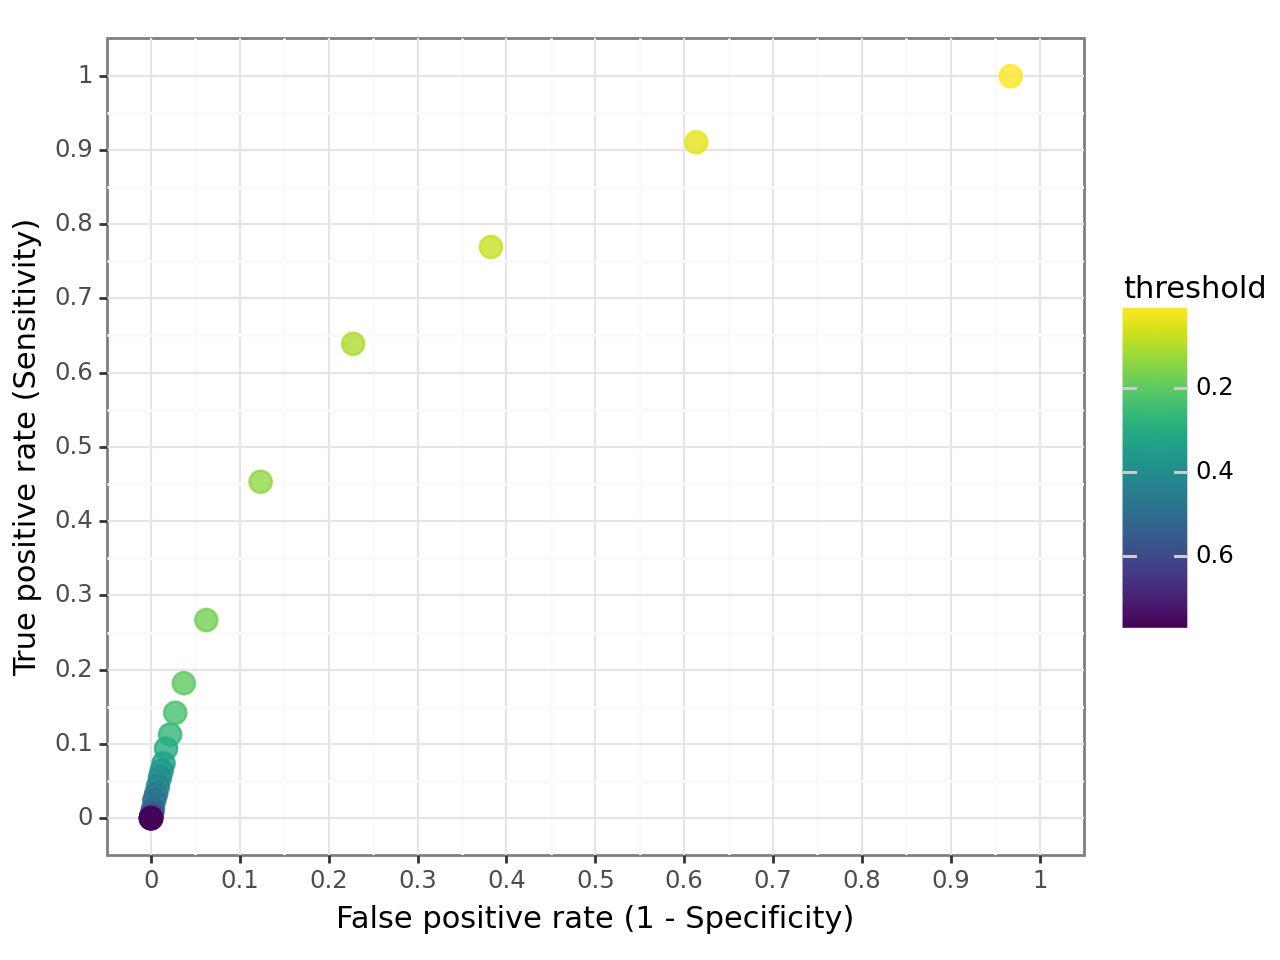

<Figure Size: (640 x 480)>

In [350]:
(
    ggplot(
        tpr_fpr_for_thresholds,
        aes(x="false_positive_rates", y="true_positive_rates", color="thresholds"),
    )
    + labs(
        x="False positive rate (1 - Specificity)", y="True positive rate (Sensitivity)"
    )
    + geom_point(size=4, alpha=0.8)
    + scale_color_continuous(trans="reverse", name="threshold")
    + scale_x_continuous(limits=(0, 1), breaks=np.arange(0, 1.01, 0.1))
    + scale_y_continuous(limits=(0, 1), breaks=np.arange(0, 1.01, 0.1))
    + theme_bw()
    + theme(legend_position="right")
)

Continuous ROC on holdout with best model

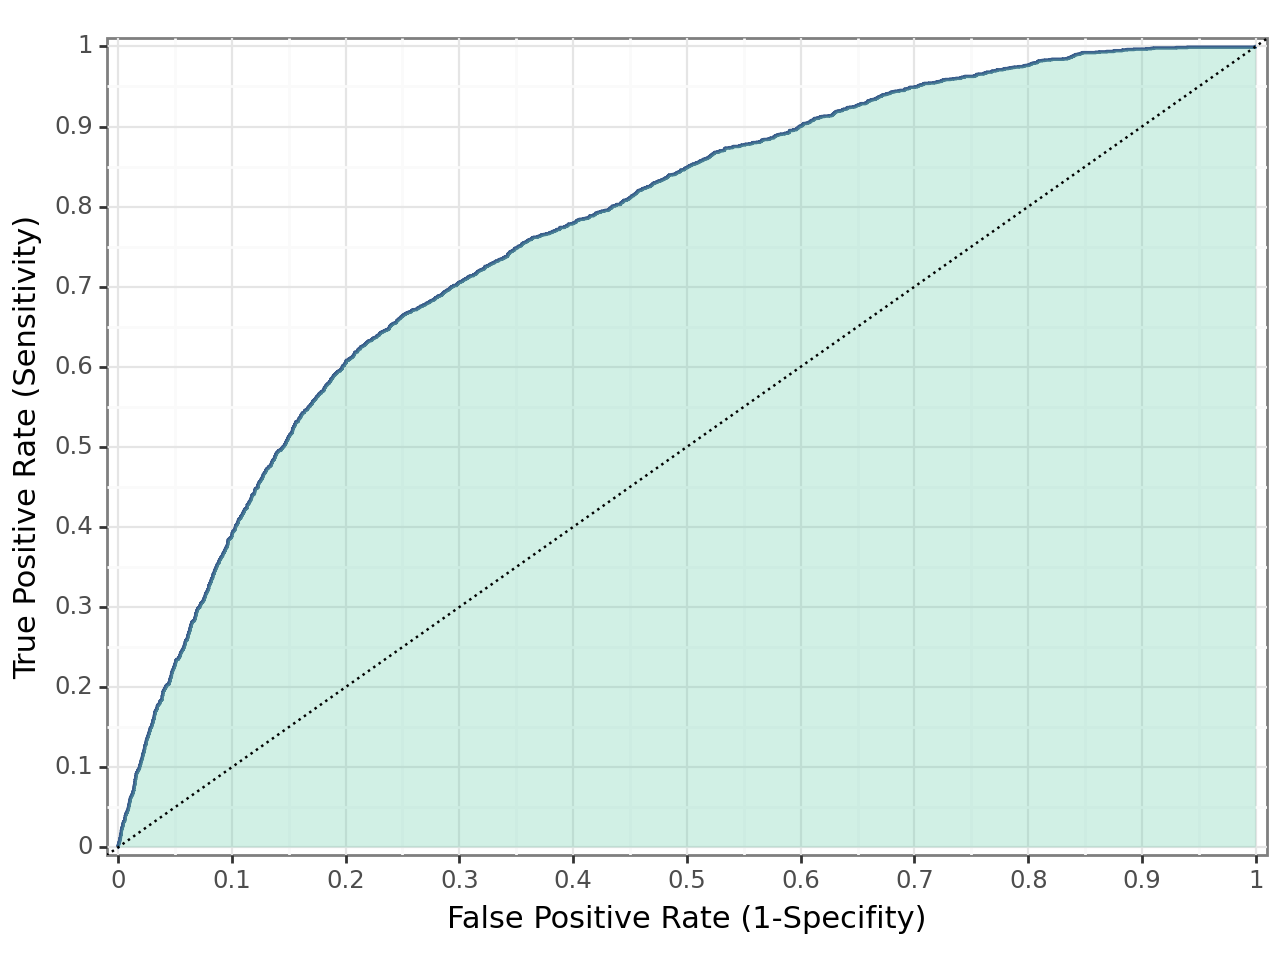

<Figure Size: (640 x 480)>

In [351]:
create_roc_plot(data_holdout["fast_growth"], data_holdout["best_logit_pred_proba"])

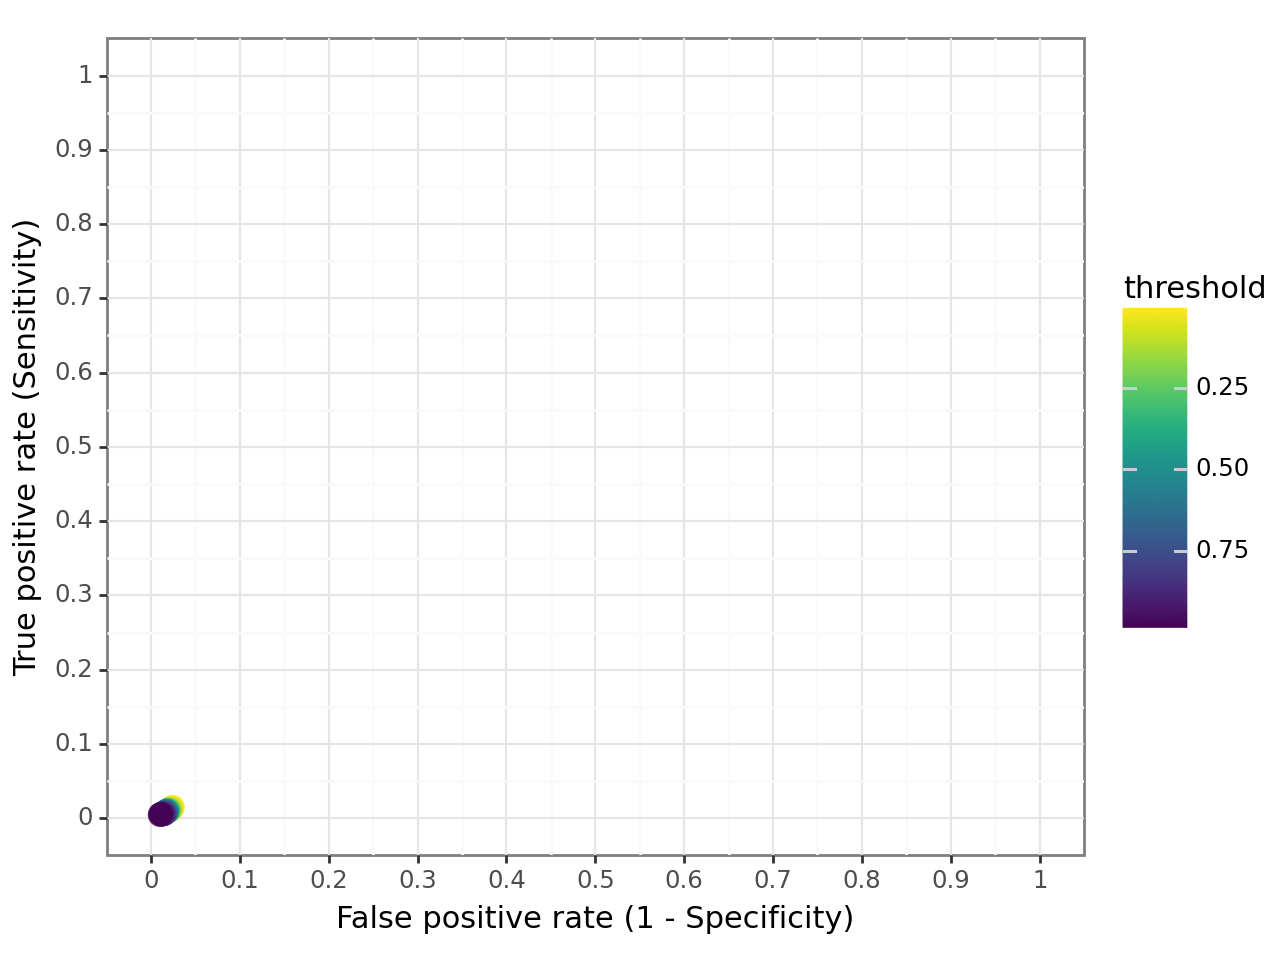

<Figure Size: (640 x 480)>

In [353]:
#Same for Lasso

thresholds = np.arange(0.03, 0.97, 0.03)
#thresholds = sorted(np.geomspace(0.95, 0.05, num=17)) # set these treshold values to get even points in the plot
cm = dict()
true_positive_rates = []
false_positive_rates = []
holdout_prediction = []
for thr in thresholds:
    holdout_prediction = np.where(data_holdout["best_lasso_pred_proba"] < thr, 0, 1)
    cm_thr = confusion_matrix(data_holdout["fast_growth"], holdout_prediction, labels=[0, 1])
    cm[thr] = cm_thr
    tn, fp, fn, tp = cm_thr.ravel()
    true_positive_rates.append(tp / (tp + fn))
    false_positive_rates.append(fp / (fp + tn))

    
tpr_fpr_for_thresholds = pd.DataFrame(
    {
        "thresholds": thresholds,
        "true_positive_rates": true_positive_rates,
        "false_positive_rates": false_positive_rates,
    }
)

(
    ggplot(
        tpr_fpr_for_thresholds,
        aes(x="false_positive_rates", y="true_positive_rates", color="thresholds"),
    )
    + labs(
        x="False positive rate (1 - Specificity)", y="True positive rate (Sensitivity)"
    )
    + geom_point(size=4, alpha=0.8)
    + scale_color_continuous(trans="reverse", name="threshold")
    + scale_x_continuous(limits=(0, 1), breaks=np.arange(0, 1.01, 0.1))
    + scale_y_continuous(limits=(0, 1), breaks=np.arange(0, 1.01, 0.1))
    + theme_bw()
    + theme(legend_position="right")
)


    

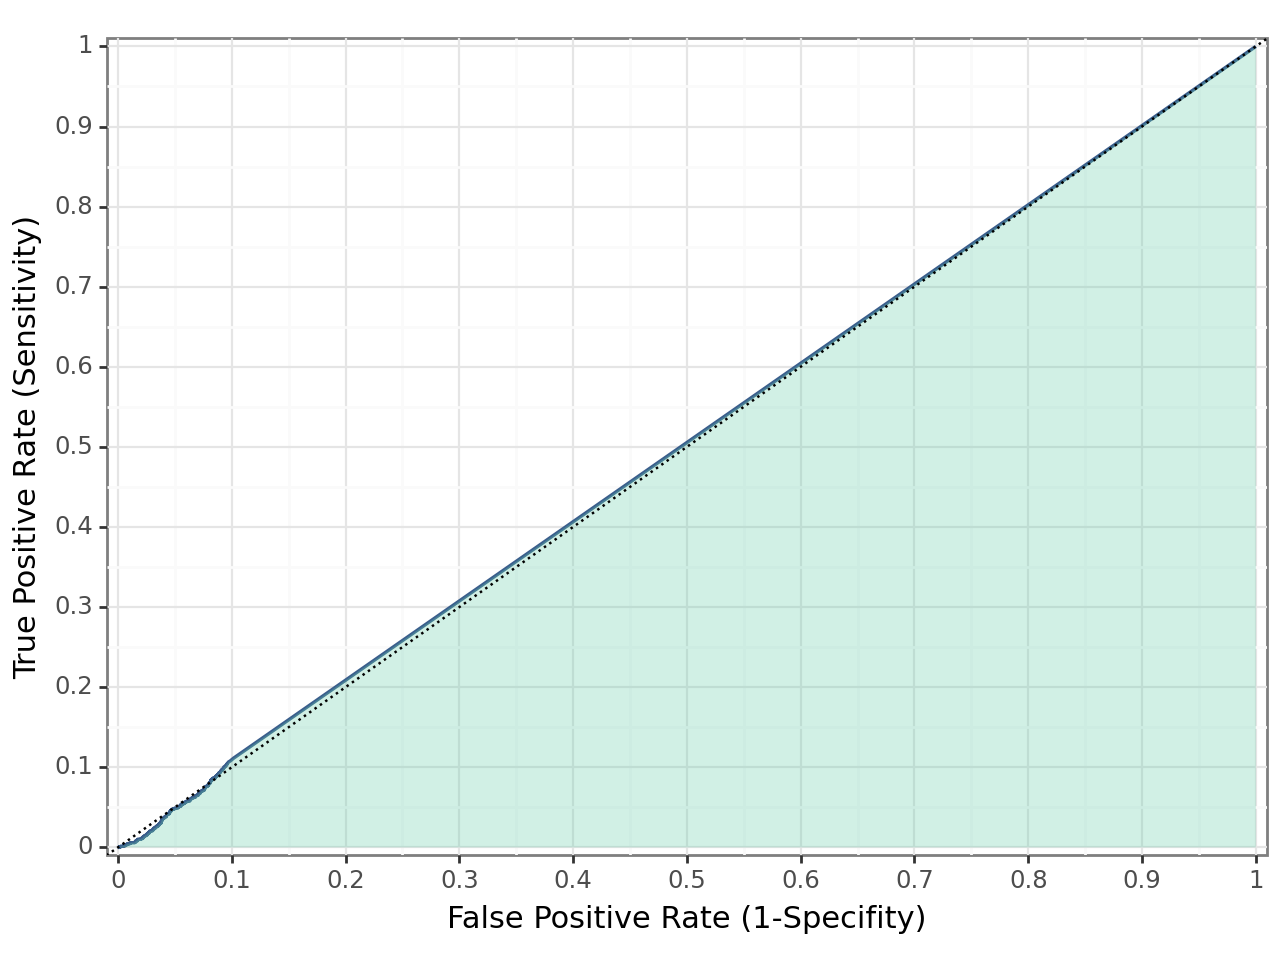

<Figure Size: (640 x 480)>

In [354]:
create_roc_plot(data_holdout["fast_growth"], data_holdout["best_lasso_pred_proba"])

Very weird......

## 3. With a loss function

Relative cost of of a false negative classification (as compared with a false positive classification)

Imagine we're an investing firm and we want to find promising firms to invest in. We want to find firms that will grow fast indeed, but we don't want to miss out on any firms that will grow fast.

There is a reason to be careful with failing investments, so to avoid false positives, but there is also a reason to be careful with missing out on good investments, so to avoid false negatives. Naturally, because among the best investments a man can make, investing in startups is among the best returners as they can grow magnitudes in a span of a few years. So we'd rather have an increasing number of false positives to have less false negatives.

If we are talking big enough firms (which we do), then an investment must be big to have an impact, so in this case we can't really expect that high returns with all fairness. But we'd expect smaller losses aswell, which balances out thing. So I'd just set it at the reciprocate of the ratio of the occurrence of the two errors based on previous results, times 10, to have a some inclination towards false negatives still.


In [406]:
FP = 1787
FN = 510
cost = 10*FN / FP

The prevalence, or the proportion of cases in the population (n.cases/(n.controls+n.cases))


In [409]:
prevelance = y_train.sum() / len(y_train)
print(prevelance)

0.09523069408055419


Draw ROC Curve and find optimal threshold with loss function 

The optimal cut-off is the threshold that maximizes the distance to the identity (diagonal) line

Iterate through:
 1. models
 2. Folds

In [410]:
best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

for i, model_name in enumerate(logit_models):
    best_thresholds = []
    expected_loss = []

    if model_name != "LASSO":
        _, X = patsy.dmatrices("fast_growth ~" + "+".join(logit_model_vars[i]), data_train)
        X = pd.DataFrame(X)
        c_index = 0
    else:
        X = normalized_logitvars
        c_index = best_lambda_i
    fold = 0
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index, :]
        y_fold = data_train["fast_growth"].iloc[test_index]
        pred_fold = generate_fold_prediction(
            logit_models[model_name], X_fold, fold, c_index
        )
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold)
        optimal_threshold = sorted(
            list(
                zip(
                    np.abs(
                        true_pos_rate
                        + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                    ),
                    thresholds,
                )
            ),
            key=lambda i: i[0],
            reverse=True,
        )[0][1]
        best_thresholds.append(optimal_threshold)
        threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
        tn, fp, fn, tp = confusion_matrix(
            y_fold, threshold_prediction, labels=[0, 1]
        ).ravel()
        curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
        expected_loss.append(curr_exp_loss)
        fold = fold + 1

    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

    # for fold #5
    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss

    all_coords = pd.DataFrame(
        {
            "false_pos": false_pos_rate * sum(y_fold == 0),
            "true_pos": true_pos_rate * sum(y_fold == 1),
            "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
            "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
            "pos": sum(y_fold == 1),
            "neg": sum(y_fold == 0),
            "n": len(y_fold),
            "thresholds": thresholds,
        }
    )

    fold5_all_coords[model_name] = all_coords

summary_with_lossfnc = pd.DataFrame(
    best_thresholds_cv.items(), columns=["Model", "Avg of optimal thresholds"]
)
summary_with_lossfnc["Threshold for Fold5"] = fold5_threshold.values()
summary_with_lossfnc["Avg expected loss"] = expected_loss_cv.values()
summary_with_lossfnc["Expected loss for Fold5"] = fold5_expected_loss.values()

In [411]:
summary_with_lossfnc

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,M1,inf,0.488658,48.940755,49.655509
1,M2,inf,0.495341,49.193064,52.674382
2,M3,inf,inf,48.567661,49.258951
3,M4,inf,inf,48.567661,49.258951
4,M5,inf,inf,48.556337,49.258951
5,LASSO,inf,0.546884,49.928260,51.285651


With this cost, the average of optimal thresholds is infinite, so I will go and just use cost = 10.

In [421]:
FP = 1
FN = 10
cost = FN / FP

best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

for i, model_name in enumerate(logit_models):
    best_thresholds = []
    expected_loss = []

    if model_name != "LASSO":
        _, X = patsy.dmatrices("fast_growth ~" + "+".join(logit_model_vars[i]), data_train)
        X = pd.DataFrame(X)
        c_index = 0
    else:
        X = normalized_logitvars
        c_index = best_lambda_i
    fold = 0
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index, :]
        y_fold = data_train["fast_growth"].iloc[test_index]
        pred_fold = generate_fold_prediction(
            logit_models[model_name], X_fold, fold, c_index
        )
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold)
        optimal_threshold = sorted(
            list(
                zip(
                    np.abs(
                        true_pos_rate
                        + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                    ),
                    thresholds,
                )
            ),
            key=lambda i: i[0],
            reverse=True,
        )[0][1]
        best_thresholds.append(optimal_threshold)
        threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
        tn, fp, fn, tp = confusion_matrix(
            y_fold, threshold_prediction, labels=[0, 1]
        ).ravel()
        curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
        expected_loss.append(curr_exp_loss)
        fold = fold + 1

    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

    # for fold #5
    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss

    all_coords = pd.DataFrame(
        {
            "false_pos": false_pos_rate * sum(y_fold == 0),
            "true_pos": true_pos_rate * sum(y_fold == 1),
            "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
            "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
            "pos": sum(y_fold == 1),
            "neg": sum(y_fold == 0),
            "n": len(y_fold),
            "thresholds": thresholds,
        }
    )

    fold5_all_coords[model_name] = all_coords

summary_with_lossfnc = pd.DataFrame(
    best_thresholds_cv.items(), columns=["Model", "Avg of optimal thresholds"]
)
summary_with_lossfnc["Threshold for Fold5"] = fold5_threshold.values()
summary_with_lossfnc["Avg expected loss"] = expected_loss_cv.values()
summary_with_lossfnc["Expected loss for Fold5"] = fold5_expected_loss.values()

In [422]:
summary_with_lossfnc

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,M1,0.094658,0.099886,0.838362,0.844074
1,M2,0.100817,0.094958,0.832845,0.840855
2,M3,0.244535,0.351329,0.882965,0.903802
3,M4,0.243984,0.351314,0.882666,0.903802
4,M5,0.246696,0.351312,0.878414,0.903802
5,LASSO,0.077782,0.086178,0.781396,0.797280


Create loss plot based on Fold5 in CV 

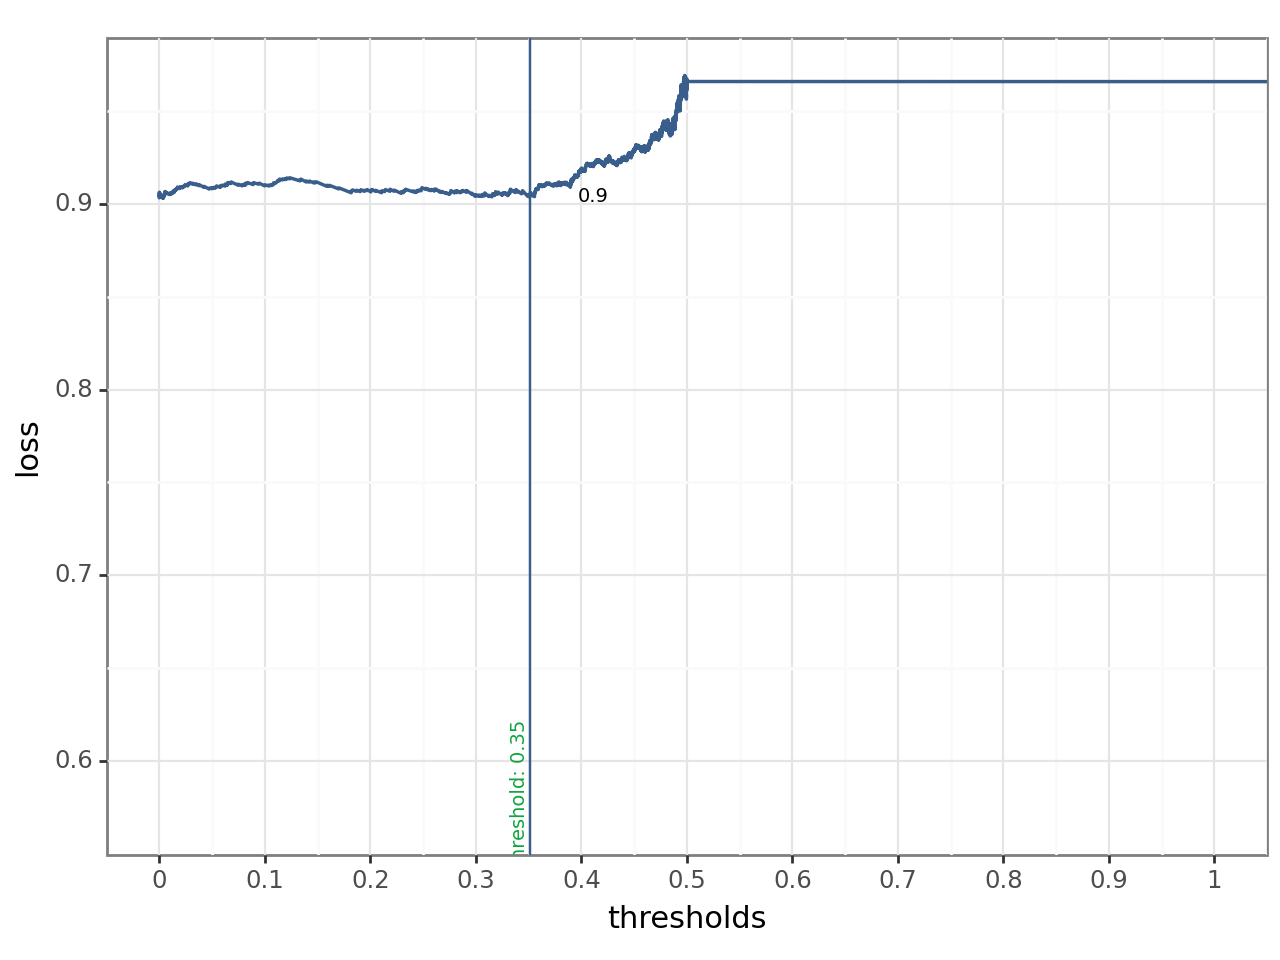

<Figure Size: (640 x 480)>

In [424]:
model_to_plot = "M4"  # select model to plot
create_loss_plot(
    fold5_all_coords[model_to_plot],
    fold5_threshold[model_to_plot],
    fold5_expected_loss[model_to_plot],
)

Create roc plot plot based on Fold5 in CV

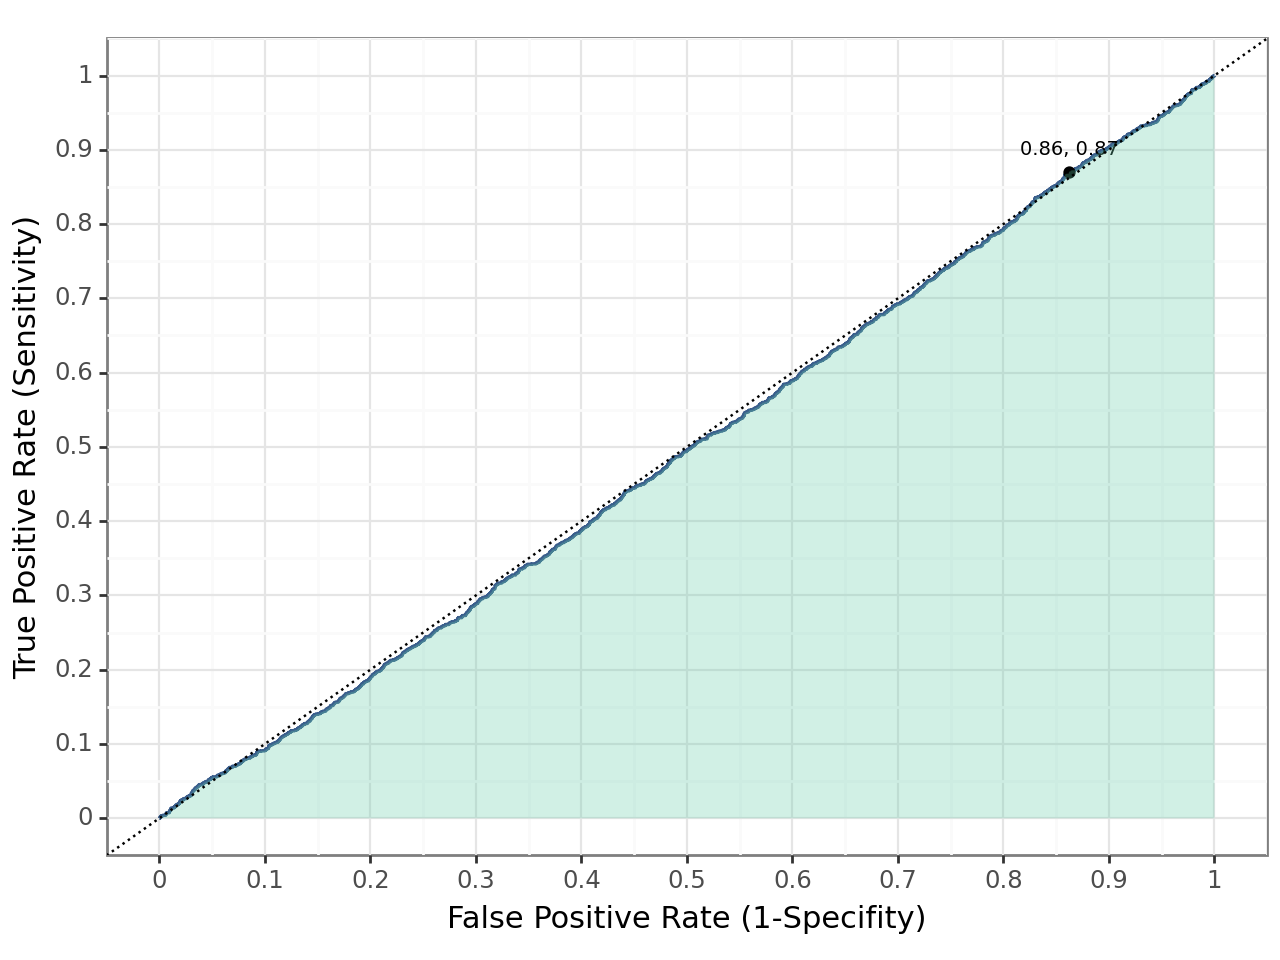

<Figure Size: (640 x 480)>

In [425]:
create_roc_plot_with_optimal(
    fold5_all_coords[model_to_plot], fold5_threshold[model_to_plot]
)


That's basically at the accuracy of a coin toss, so not very good. How about M1, which did best?

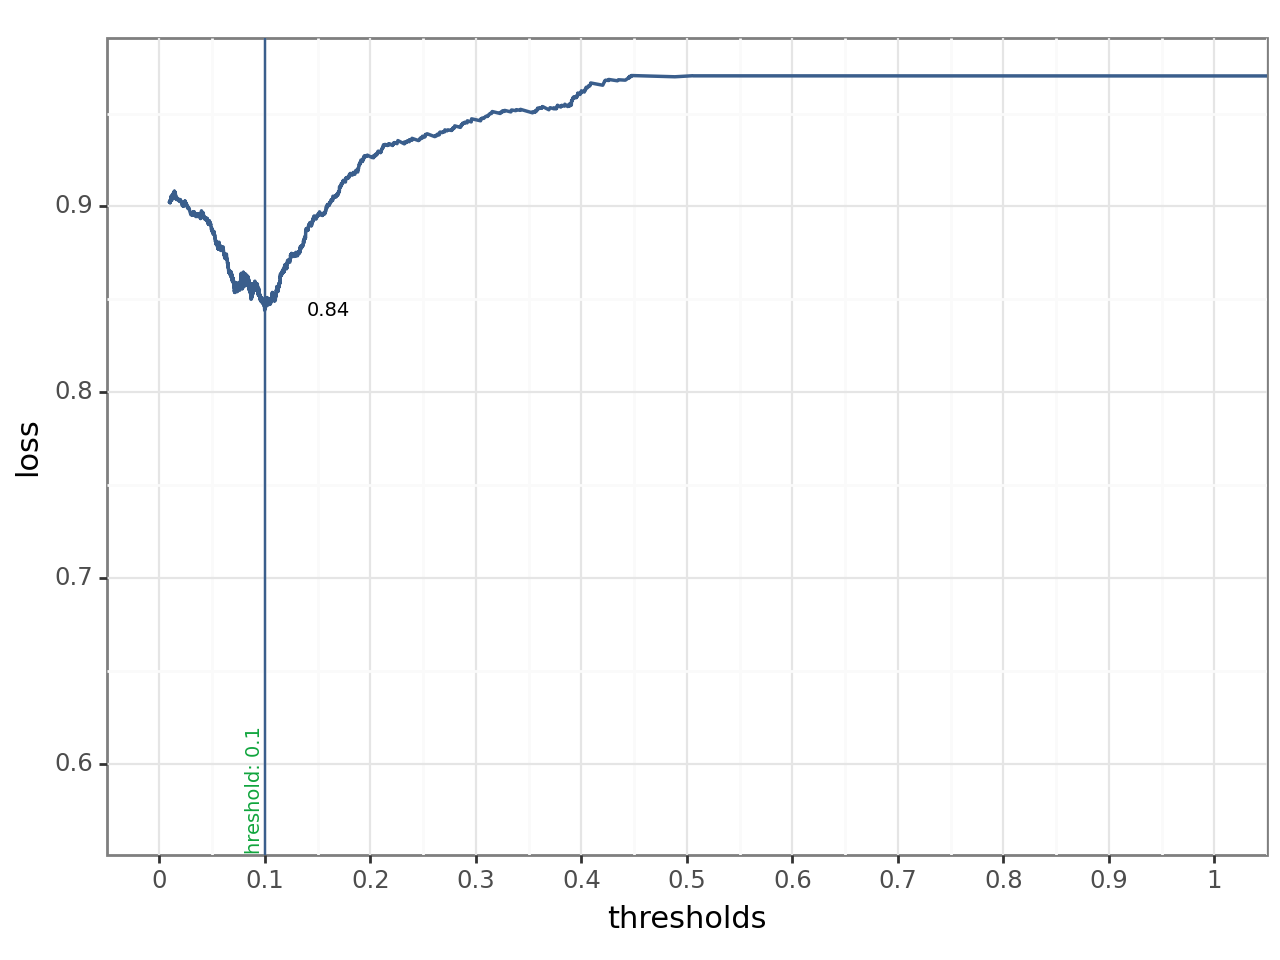

<Figure Size: (640 x 480)>

In [426]:
model_to_plot = "M1"  # select model to plot
create_loss_plot(
    fold5_all_coords[model_to_plot],
    fold5_threshold[model_to_plot],
    fold5_expected_loss[model_to_plot],
)

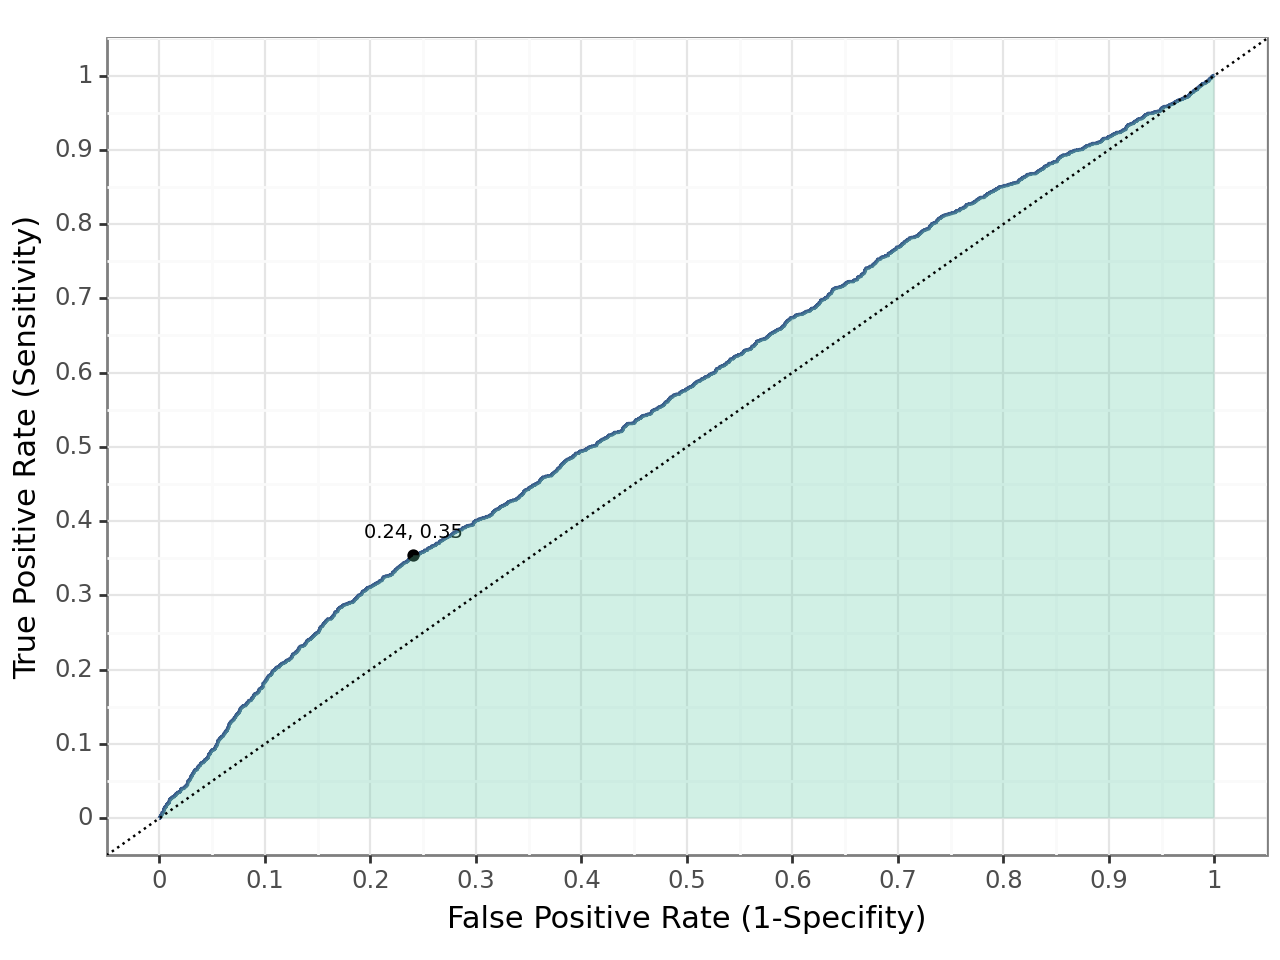

<Figure Size: (640 x 480)>

In [427]:
create_roc_plot_with_optimal(
    fold5_all_coords[model_to_plot], fold5_threshold[model_to_plot]
)


Let's see our chosen model, M1's holdout expected loss

In [437]:
best_logit_optimal_treshold = best_thresholds_cv["M1"]

# Get expected loss on holdout
holdout_treshold = np.where(
    data_holdout["best_logit_pred_proba"] < best_logit_optimal_treshold, 0, 1
)
tn, fp, fn, tp = confusion_matrix(
    data_holdout["fast_growth"], holdout_treshold, labels=[0, 1]
).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(data_holdout["fast_growth"])
round(expected_loss_holdout, 3)

0.549

CM on holdout

In [438]:
cm_object3 = confusion_matrix(data_holdout["fast_growth"], holdout_treshold, labels=[0, 1])
cm3 = pd.DataFrame(
    cm_object3,
    index=["Actul no fast_growth", "Actual fast_growth"],
    columns=["Predicted no fast_growth", "Predicted fast_growth"],
)
cm3

,Predicted no fast_growth,Predicted fast_growth
Actul no fast_growth,13215,7249
Actual fast_growth,512,1545


# PREDICTION WITH RANDOM FOREST

In [439]:
y_train, rfvars_train = patsy.dmatrices("fast_growth~" + "+".join(rfvars), data_train)
y_holdout, rfvars_holdout = patsy.dmatrices("fast_growth~" + "+".join(rfvars), data_holdout)

## Graph example for decision tree

<Figure size 640x480 with 0 Axes>

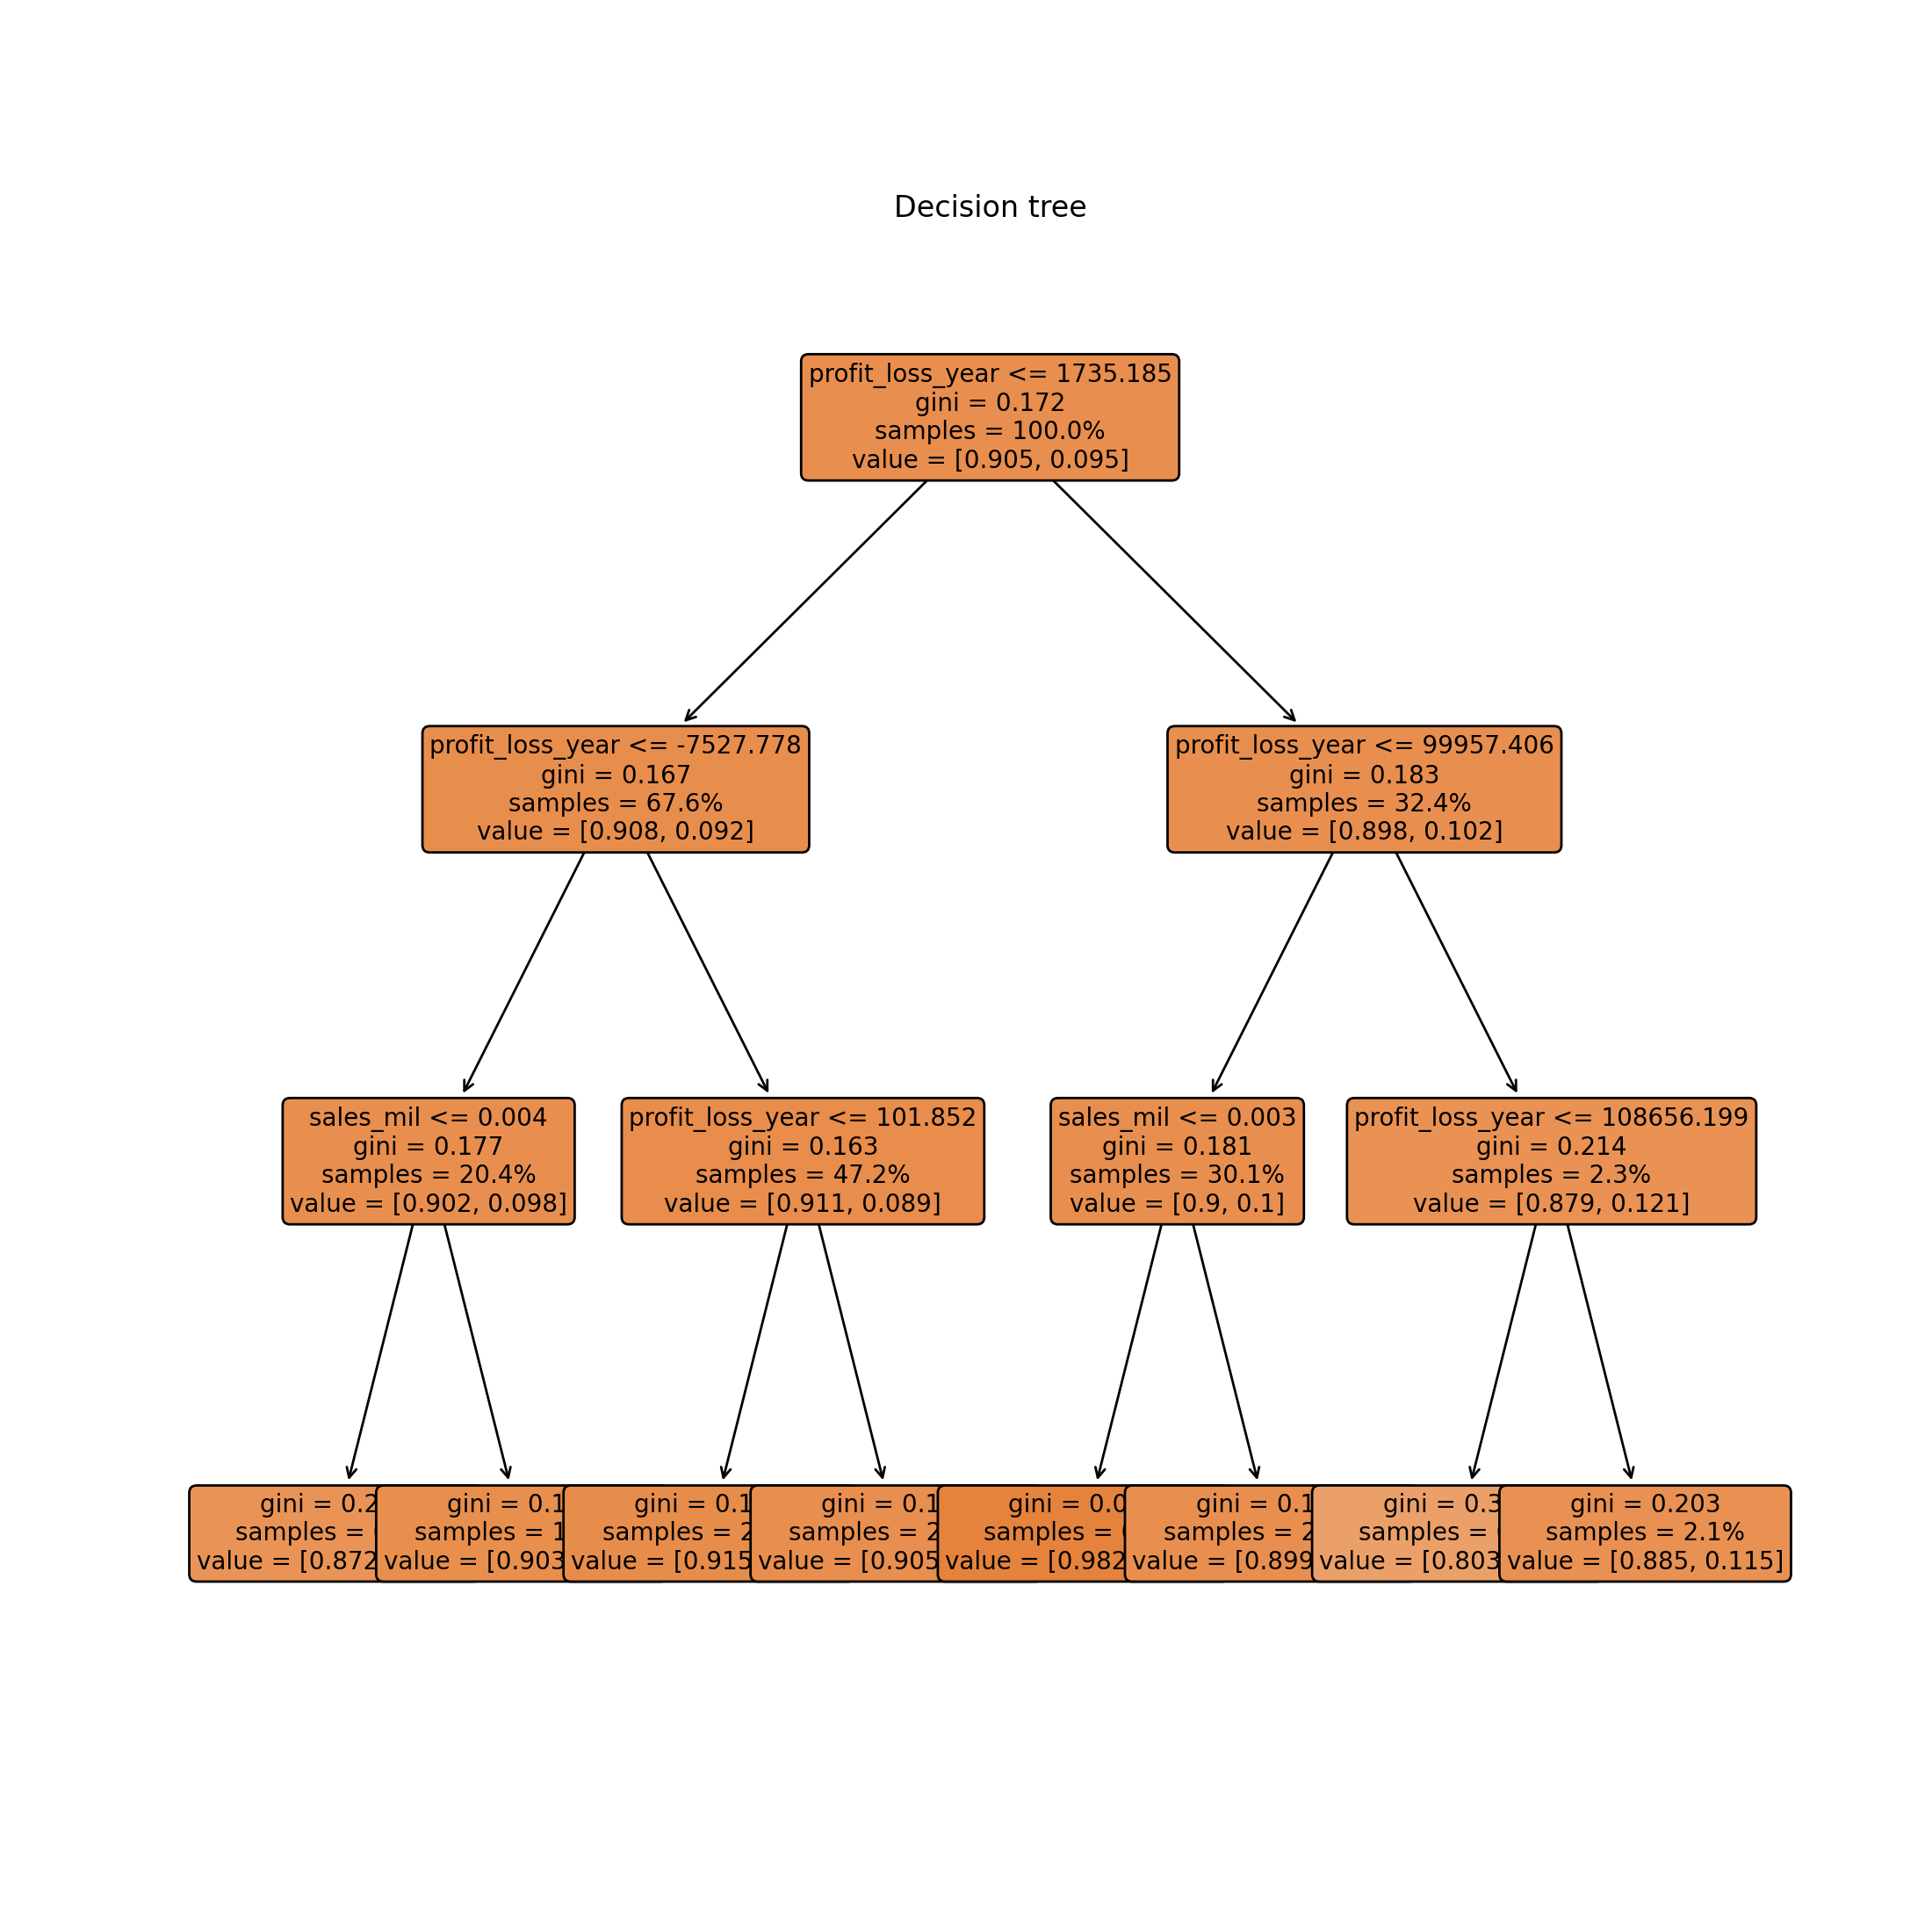

In [451]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

#data_train_df = pd.DataFrame(data_train, columns=data_train.design_info.column_names)
y_train_df = pd.DataFrame(y_train, columns=['target'])

data_for_graph = data_train[["sales_mil", "profit_loss_year", "foreign_management"]].iloc[:90076]
y_train_df = y_train_df.iloc[:90076]

rf_for_graph = DecisionTreeClassifier(
    max_depth=3, random_state=41
).fit(data_for_graph, y_train_df)

plt.figure()
plt.figure(figsize=(11, 11))
plot_tree(
    rf_for_graph,
    feature_names=data_for_graph.columns,
    filled=True,
    rounded=True,
    proportion=True,
    fontsize=10,
)
plt.title("Decision tree")
plt.show()


## Probability forest

Split by gini, ratio of 1's in each tree, average over trees

In [452]:
grid = {
    "max_features": [5, 6, 7],
    "criterion": ["gini"],
    "min_samples_split": [11, 16],
} 

5 fold cross validation

In [453]:
prob_forest = RandomForestClassifier(random_state=42, n_estimators=500, oob_score=True)
prob_forest_grid = GridSearchCV(
    prob_forest,
    grid,
    cv=k,
    refit="roc_auc",
    scoring=["roc_auc", "neg_brier_score"],
)

In [454]:
prob_forest_fit = prob_forest_grid.fit(rfvars_train, y_train)

Create CV summary table

In [455]:
prob_forest_cv_results = pd.DataFrame(
    {
        "max_features": prob_forest_fit.cv_results_["param_max_features"],
        "min_samples_split": prob_forest_fit.cv_results_["param_min_samples_split"],
        "cv_auc": prob_forest_fit.cv_results_["mean_test_roc_auc"],
        "cv_rmse": np.sqrt(
            prob_forest_fit.cv_results_["mean_test_neg_brier_score"] * -1
        ),
    }
)

prob_forest_cv_results

,max_features,min_samples_split,cv_auc,cv_rmse
0,5,11,0.862844,0.267386
1,5,16,0.863215,0.267354
2,6,11,0.863926,0.267208
3,6,16,0.864298,0.267098
4,7,11,0.864674,0.267156
5,7,16,0.864946,0.267000


Obtain optimal parameter values

In [456]:
best_mtry = prob_forest_fit.best_params_["max_features"]
best_min_node_size = prob_forest_fit.best_params_["min_samples_split"]
prob_forest_fit.best_params_


{'criterion': 'gini', 'max_features': 7, 'min_samples_split': 16}

Get average (ie over the folds) RMSE and AUC

In [457]:
prob_forest_best_results = prob_forest_cv_results[
    (prob_forest_cv_results.max_features == best_mtry)
    & (prob_forest_cv_results.min_samples_split == best_min_node_size)
]
prob_forest_best_results_index = prob_forest_best_results.index.values[0]

In [458]:
summary.loc["RF", "Number of Coefficients"] = "n.a."
summary.loc["RF", "CV RMSE"] = prob_forest_best_results["cv_rmse"].values[0]
summary.loc["RF", "CV AUC"] = prob_forest_best_results["cv_auc"].values[0]
summary

,Number of Coefficients,CV RMSE,CV AUC
M1,12.0,0.285929,0.725521
M2,19.0,0.284122,0.737328
M3,36.0,0.430273,0.536885
M4,76.0,0.430309,0.536466
M5,151.0,0.429649,0.545269
LASSO,106.0,0.273869,0.837628
RF,n.a.,0.267000,0.864946


Extract fold level RMSE and AUC

In [459]:
CV_RMSE_folds["RF"] = np.sqrt(
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_neg_brier_score")
    .loc[lambda x: x["rank_test_neg_brier_score"] == 1]
    .filter(like="split")
    .values[0]
    * -1
)
CV_AUC_folds["RF"] = (
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_roc_auc")
    .loc[lambda x: x["rank_test_roc_auc"] == 1]
    .filter(like="split")
    .values[0]
)

Take a look at foldwise RMSE and AUC

In [460]:
pd.DataFrame(CV_RMSE_folds)

,M1,M2,M3,M4,M5,LASSO,RF
0,0.281675,0.280281,0.469000,0.468999,0.468999,0.275414,0.267414
1,0.286538,0.284391,0.465060,0.465056,0.465056,0.271327,0.264727
2,0.286087,0.284359,0.285614,0.285802,0.282504,0.275045,0.268301
3,0.288727,0.286810,0.469106,0.469106,0.469105,0.274685,0.267364
4,0.286618,0.284769,0.462586,0.462583,0.462583,0.272875,0.267180


In [461]:
pd.DataFrame(CV_AUC_folds)

,M1,M2,M3,M4,M5,LASSO,RF
0,0.726822,0.735306,0.482911,0.482910,0.482911,0.835236,0.867366
1,0.722837,0.736182,0.476982,0.476981,0.476981,0.835491,0.861992
2,0.717797,0.733855,0.737516,0.735427,0.779440,0.836627,0.860120
3,0.730474,0.738035,0.494278,0.494277,0.494277,0.840759,0.869278
4,0.729675,0.743263,0.492737,0.492736,0.492735,0.840024,0.865976


Now use loss function and search for best thresholds and expected loss over folds 

In [462]:
best_thresholds = list()
expected_loss = list()
rfvars_train = pd.DataFrame(rfvars_train)

fold = 0
for train_index, test_index in k.split(rfvars_train):
    X_fold = rfvars_train.iloc[test_index, :]
    y_fold = data_train["fast_growth"].iloc[test_index]

    X_fold_train = rfvars_train.iloc[train_index, :]
    y_fold_train = data_train["fast_growth"].iloc[train_index]

    prob_forest_best = RandomForestClassifier(
        random_state=42,
        n_estimators=500,
        oob_score=True,
        criterion="gini",
        max_features=best_mtry,
        min_samples_split=best_min_node_size,
    )
    prob_forest_best_fold = prob_forest_best.fit(X_fold_train, y_fold_train)
    pred_fold = prob_forest_best_fold.predict_proba(X_fold)[:, 1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    best_threshold = sorted(
        list(
            zip(
                np.abs(
                    true_pos_rate
                    + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                ),
                threshold,
            )
        ),
        key=lambda x: x[0],
        reverse=True,
    )[0][1]
    best_thresholds.append(best_threshold)
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(
        y_fold, threshold_prediction, labels=[0, 1]
    ).ravel()
    curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
    expected_loss.append(curr_exp_loss)

fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame(
    {
        "false_pos": false_pos_rate * sum(y_fold == 0),
        "true_pos": true_pos_rate * sum(y_fold == 1),
        "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
        "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
        "pos": sum(y_fold == 1),
        "neg": sum(y_fold == 0),
        "n": len(y_fold),
        "thresholds": threshold,
    }
)


In [463]:
expected_loss_cv["RF"] = np.mean(expected_loss)
best_thresholds_cv["RF"] = np.mean(best_thresholds)


In [464]:
rf_summary = pd.DataFrame(
    {
        "CV RMSE": [round(prob_forest_best_results["cv_rmse"].values[0], 3)],
        "CV AUC": [round(prob_forest_best_results["cv_auc"].values[0], 3)],
        "Avg of optimal thresholds": [round(best_thresholds_cv["RF"], 3)],
        "Threshold for Fold5": [round(best_threshold, 3)],
        "Avg expected loss": [round(expected_loss_cv["RF"], 3)],
        "Expected loss for Fold5": [round(curr_exp_loss, 3)],
    }
)

rf_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.267,0.865,0.095,0.108,0.82,0.835


Create plots based on Fold5 in CV 

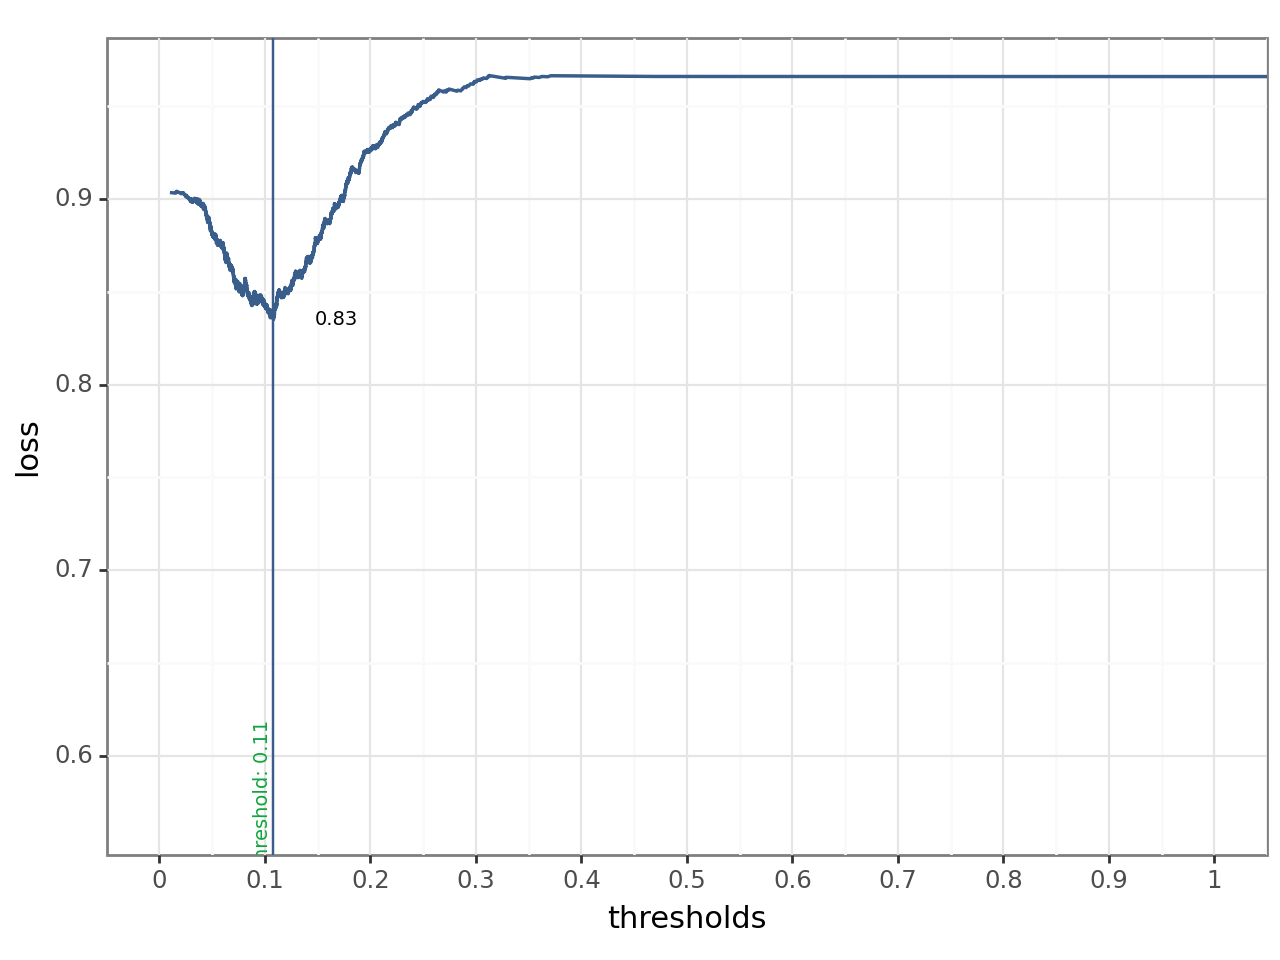

<Figure Size: (640 x 480)>

In [465]:
create_loss_plot(all_coords_rf, fold5_threshold_rf, fold5_expected_loss_rf)

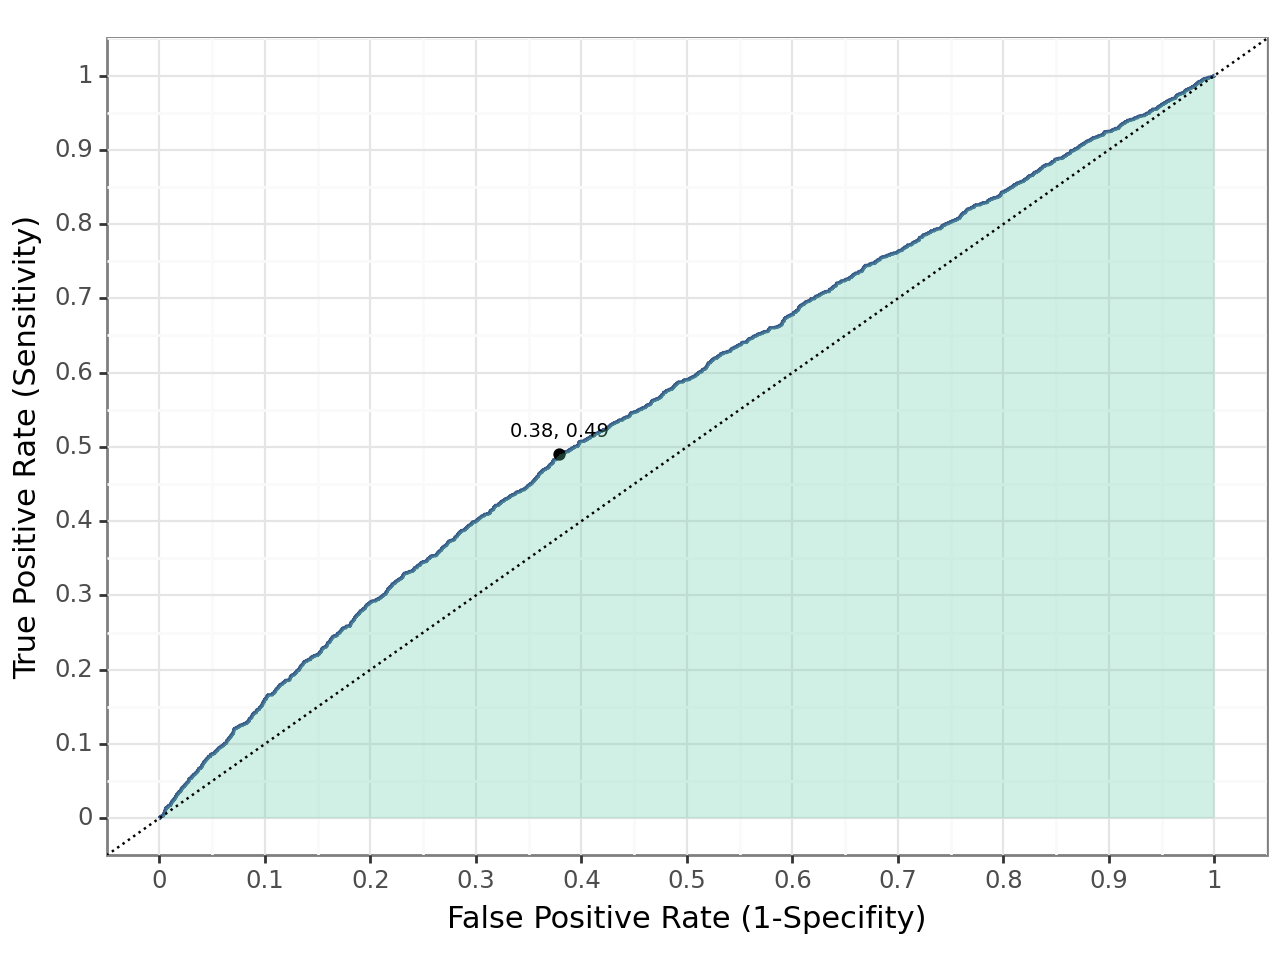

<Figure Size: (640 x 480)>

In [466]:
create_roc_plot_with_optimal(all_coords_rf, fold5_threshold_rf)

Take model to holdout and estimate RMSE, AUC and expected loss 

In [467]:
prob_forest_fit_best = prob_forest_fit.best_estimator_
rf_predicted_probabilities_holdout = prob_forest_fit_best.predict_proba(rfvars_holdout)[
    :, 1
]
rmse_rf = np.sqrt(mean_squared_error(y_holdout, rf_predicted_probabilities_holdout))
round(rmse_rf, 3)


0.263

ROC AUC  on holdout

In [468]:
auc_rf = roc_auc_score(y_holdout, rf_predicted_probabilities_holdout)
round(auc_rf, 3)


0.867

 Get expected loss on holdout

In [469]:
holdout_treshold = np.where(
    rf_predicted_probabilities_holdout < best_thresholds_cv["RF"], 0, 1
)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0, 1]).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(y_holdout)
round(expected_loss_holdout, 3)


0.34

## Final results

In [470]:
summary["CV treshold"] = best_thresholds_cv
summary["CV expected Loss"] = expected_loss_cv

In [471]:
summary

,Number of Coefficients,CV RMSE,CV AUC,CV treshold,CV expected Loss
M1,12.0,0.285929,0.725521,0.094658,0.838362
M2,19.0,0.284122,0.737328,0.100817,0.832845
M3,36.0,0.430273,0.536885,0.244535,0.882965
M4,76.0,0.430309,0.536466,0.243984,0.882666
M5,151.0,0.429649,0.545269,0.246696,0.878414
LASSO,106.0,0.273869,0.837628,0.077782,0.781396
RF,n.a.,0.267000,0.864946,0.094684,0.819963


# Test on industry data

In [501]:
X_holdout_df = pd.DataFrame(X_holdout, columns=X_holdout.design_info.column_names)
X_holdout_df

,Intercept,C(ind2_cat)[T.27.0],C(ind2_cat)[T.28.0],C(ind2_cat)[T.29.0],C(ind2_cat)[T.30.0],C(ind2_cat)[T.33.0],C(ind2_cat)[T.55.0],C(ind2_cat)[T.56.0],C(m_region_loc)[T.East],C(m_region_loc)[T.West],...,flag_low_d1_sales_mil_log,flag_high_d1_sales_mil_log,female,ceo_count,labor_avg_mod,flag_miss_labor_avg,foreign_management,balsheet_flag,balsheet_length,balsheet_notfullyear
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.083333,0.0,0.0,0.0,364.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.666564,1.0,0.0,0.0,365.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.666564,1.0,0.0,0.0,364.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.166667,0.0,1.0,0.0,364.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.361111,0.0,0.0,0.0,365.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22516,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.125000,0.0,0.0,0.0,364.0,0.0
22517,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.666564,1.0,0.0,0.0,364.0,0.0
22518,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.856061,0.0,0.0,0.0,364.0,0.0
22519,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.666564,1.0,0.0,0.0,364.0,0.0


In [506]:
X_holdout_df.columns[:]

Index(['Intercept', 'C(ind2_cat)[T.27.0]', 'C(ind2_cat)[T.28.0]',
       'C(ind2_cat)[T.29.0]', 'C(ind2_cat)[T.30.0]', 'C(ind2_cat)[T.33.0]',
       'C(ind2_cat)[T.55.0]', 'C(ind2_cat)[T.56.0]', 'C(m_region_loc)[T.East]',
       'C(m_region_loc)[T.West]', 'C(urban_m)[T.2.0]', 'C(urban_m)[T.3.0]',
       'sales_mil_log', 'sales_mil_log_sq', 'age', 'age2', 'new',
       'total_assets_bs', 'fixed_assets_bs', 'liq_assets_bs', 'curr_assets_bs',
       'share_eq_bs', 'subscribed_cap_bs', 'intang_assets_bs', 'extra_exp_pl',
       'extra_inc_pl', 'extra_profit_loss_pl', 'inc_bef_tax_pl',
       'inventories_pl', 'material_exp_pl', 'profit_loss_year_pl',
       'personnel_exp_pl', 'extra_profit_loss_pl_quad', 'inc_bef_tax_pl_quad',
       'profit_loss_year_pl_quad', 'share_eq_bs_quad',
       'extra_exp_pl_flag_high', 'extra_inc_pl_flag_high',
       'inventories_pl_flag_high', 'material_exp_pl_flag_high',
       'personnel_exp_pl_flag_high', 'curr_liab_bs_flag_high',
       'liq_assets_bs_fla

In [525]:
#Test models on holdout with industry ID less than 35 
#ID: from NACE 2-digit

data_holdout_manufacture = (data_holdout[((data_holdout["ind2_cat"]>26) & (data_holdout["ind2_cat"]<31) )| (data_holdout["ind2_cat"] == 33)]).reset_index(drop=True)
data_holdout_food_accom = (data_holdout[(data_holdout["ind2_cat"] == 55)|(data_holdout["ind2_cat"] == 56)]).reset_index(drop=True)

X_holdout_manufacture = (X_holdout_df[(X_holdout_df['C(ind2_cat)[T.27.0]'] == 1) | (X_holdout_df['C(ind2_cat)[T.28.0]'] == 1) | (X_holdout_df['C(ind2_cat)[T.29.0]'] == 1) | (X_holdout_df['C(ind2_cat)[T.30.0]'] == 1) | (X_holdout_df['C(ind2_cat)[T.33.0]'] == 1) ]).reset_index(drop=True)
X_holdout_food_accom = (X_holdout_df[(X_holdout_df['C(ind2_cat)[T.55.0]'] == 1) | (X_holdout_df['C(ind2_cat)[T.56.0]'] == 1)]).reset_index(drop=True)

#Test models on the two holdout samples
#Logit M1
data_holdout_manufacture["best_logit_pred_proba"] = best_logit.predict_proba(X_holdout_manufacture)[:, 1]
print(round(rmse(data_holdout_manufacture["best_logit_pred_proba"], data_holdout_manufacture["fast_growth"]), 3))
print(round(roc_auc_score(data_holdout_manufacture["fast_growth"], data_holdout_manufacture["best_logit_pred_proba"]), 3))

data_holdout_food_accom["best_logit_pred_proba"] = best_logit.predict_proba(X_holdout_food_accom)[:, 1]
print(round(rmse(data_holdout_food_accom["best_logit_pred_proba"], data_holdout_food_accom["fast_growth"]), 3))
print(round(roc_auc_score(data_holdout_food_accom["fast_growth"], data_holdout_food_accom["best_logit_pred_proba"]), 3))

0.276
0.761
0.278
0.773


In [530]:
#Confusion matrix for M1 on the two holdout samples

#Manufacture
holdout_prediction = np.where(data_holdout_manufacture["best_logit_pred_proba"] < 0.5, 0, 1)
cm_object1 = confusion_matrix(
    data_holdout_manufacture["fast_growth"], holdout_prediction, labels=[0, 1]
)
cm1 = pd.DataFrame(
    cm_object1,
    index=["Actual no fast growth", "Actual fast growth"],
    columns=["Predicted no fast growth", "Predicted fast growth"],
)
cm1

,Predicted no fast growth,Predicted fast growth
Actual no fast growth,4932,12
Actual fast growth,479,10


In [531]:
#Food and accomodation
holdout_prediction = np.where(data_holdout_food_accom["best_logit_pred_proba"] < 0.5, 0, 1)
cm_object2 = confusion_matrix(
    data_holdout_food_accom["fast_growth"], holdout_prediction, labels=[0, 1]
)
cm2 = pd.DataFrame(
    cm_object2,
    index=["Actual no fast growth", "Actual fast growth"],
    columns=["Predicted no fast growth", "Predicted fast growth"],
)
cm2

,Predicted no fast growth,Predicted fast growth
Actual no fast growth,14353,43
Actual fast growth,1450,23


In [534]:
rfvars_holdout_df = pd.DataFrame(rfvars_holdout, columns=rfvars_holdout.design_info.column_names)
rfvars_holdout_manufacture = (rfvars_holdout_df[((rfvars_holdout_df['C(ind2_cat)[T.27.0]'] == 1) | (rfvars_holdout_df['C(ind2_cat)[T.28.0]'] == 1) | (rfvars_holdout_df['C(ind2_cat)[T.29.0]'] == 1) | (rfvars_holdout_df['C(ind2_cat)[T.30.0]'] == 1) | (rfvars_holdout_df['C(ind2_cat)[T.33.0]'] == 1) )]).reset_index(drop=True)
rfvars_holdout_food_accom = (rfvars_holdout_df[((rfvars_holdout_df['C(ind2_cat)[T.55.0]'] == 1) | (rfvars_holdout_df['C(ind2_cat)[T.56.0]'] == 1))]).reset_index(drop=True)



In [536]:

#Random Forest
data_holdout_manufacture["best_rf_pred_proba"] = prob_forest_fit_best.predict_proba(rfvars_holdout_manufacture)[:, 1]
data_holdout_food_accom["best_rf_pred_proba"] = prob_forest_fit_best.predict_proba(rfvars_holdout_food_accom)[:, 1]
print(round(rmse(data_holdout_manufacture["best_rf_pred_proba"], data_holdout_manufacture["fast_growth"]), 3))
print(round(roc_auc_score(data_holdout_manufacture["fast_growth"], data_holdout_manufacture["best_rf_pred_proba"]), 3))
print(round(rmse(data_holdout_food_accom["best_rf_pred_proba"], data_holdout_food_accom["fast_growth"]), 3))
print(round(roc_auc_score(data_holdout_food_accom["fast_growth"], data_holdout_food_accom["best_rf_pred_proba"]), 3))

0.263
0.861
0.264
0.869


In [554]:
#Confusion matrix for RF on the two holdout samples

#Manufacture
holdout_prediction = np.where(data_holdout_manufacture["best_rf_pred_proba"] < 0.5, 0, 1)
cm_object1 = confusion_matrix(
    data_holdout_manufacture["fast_growth"], holdout_prediction, labels=[0, 1]
)
cm1 = pd.DataFrame(
    cm_object1,
    index=["Actual no fast growth", "Actual fast growth"],
    columns=["Predicted no fast growth", "Predicted fast growth"],
)
cm1

,Predicted no fast growth,Predicted fast growth
Actual no fast growth,4939,5
Actual fast growth,486,3


In [555]:
#Food and accomodation
holdout_prediction = np.where(data_holdout_food_accom["best_rf_pred_proba"] < 0.5, 0, 1)
cm_object2 = confusion_matrix(
    data_holdout_food_accom["fast_growth"], holdout_prediction, labels=[0, 1]
)
cm2 = pd.DataFrame(
    cm_object2,
    index=["Actual no fast growth", "Actual fast growth"],
    columns=["Predicted no fast growth", "Predicted fast growth"],
)
cm2

,Predicted no fast growth,Predicted fast growth
Actual no fast growth,14384,12
Actual fast growth,1452,21


In [553]:
#Lasso
X_holdout_lasso_df = pd.DataFrame(X_holdout_lasso, columns=X_holdout_lasso.design_info.column_names)
X_holdout_lasso_manufacture = (X_holdout_lasso_df[(X_holdout_lasso_df['C(ind2_cat)[T.27.0]'] == 1) | (X_holdout_lasso_df['C(ind2_cat)[T.28.0]'] == 1) | (X_holdout_lasso_df['C(ind2_cat)[T.29.0]'] == 1) | (X_holdout_lasso_df['C(ind2_cat)[T.30.0]'] == 1) | (X_holdout_lasso_df['C(ind2_cat)[T.33.0]'] == 1) ]).reset_index(drop=True)
X_holdout_lasso_food_accom = (X_holdout_lasso_df[(X_holdout_lasso_df['C(ind2_cat)[T.55.0]'] == 1) | (X_holdout_lasso_df['C(ind2_cat)[T.56.0]'] == 1)]).reset_index(drop=True)


data_holdout_manufacture["best_lasso_pred_proba"]= 1-lasso.predict_proba(X_holdout_lasso_manufacture)[:, 1]
print(round(rmse(data_holdout_manufacture["fast_growth"], data_holdout_manufacture["best_lasso_pred_proba"]), 3))
print(round(roc_auc_score(data_holdout_manufacture["fast_growth"], data_holdout_manufacture["best_lasso_pred_proba"]), 3))

data_holdout_food_accom["best_lasso_pred_proba"]= 1-lasso.predict_proba(X_holdout_lasso_food_accom)[:, 1]
print(round(rmse(data_holdout_food_accom["fast_growth"], data_holdout_food_accom["best_lasso_pred_proba"]), 3))
round(roc_auc_score(data_holdout_food_accom["fast_growth"], data_holdout_food_accom["best_lasso_pred_proba"]), 3)


0.305
0.51
0.331


0.501

In [556]:
#Confusion matrix for Lasso on the two holdout samples

#Manufacture
holdout_prediction = np.where(data_holdout_manufacture["best_lasso_pred_proba"] < 0.5, 0, 1)
cm_object1 = confusion_matrix(
    data_holdout_manufacture["fast_growth"], holdout_prediction, labels=[0, 1]
)
cm1 = pd.DataFrame(
    cm_object1,
    index=["Actual no fast growth", "Actual fast growth"],
    columns=["Predicted no fast growth", "Predicted fast growth"],
)
cm1


,Predicted no fast growth,Predicted fast growth
Actual no fast growth,4925,19
Actual fast growth,488,1


In [557]:
#Food and accomodation
holdout_prediction = np.where(data_holdout_food_accom["best_lasso_pred_proba"] < 0.5, 0, 1)
cm_object2 = confusion_matrix(
    data_holdout_food_accom["fast_growth"], holdout_prediction, labels=[0, 1]
)
cm2 = pd.DataFrame(
    cm_object2,
    index=["Actual no fast growth", "Actual fast growth"],
    columns=["Predicted no fast growth", "Predicted fast growth"],
)
cm2


,Predicted no fast growth,Predicted fast growth
Actual no fast growth,14070,326
Actual fast growth,1457,16
